# Outline
- ### <a href='#1'>1. GMM self-implementation</a>
- ### <a href='#2'>2. GMM with 1D generated datasets</a>
- ### <a href='#3'>3. GMM with 2D datasets</a>
- ### <a href='#4'>4. GMM for generating handwritten digits</a>

# <a id='1'>1. GMM self-implementation

Import các thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
from sklearn import datasets
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings("ignore")
colors = ['purple', 'k', 'r', 'g', 'b']

Ta sẽ implement hàm để tính giá trị này:
\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{D/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}

In [2]:
# X: (n x d), mu: (d x 1), cov: (d x d)   ~   n data points, d dimenions
# return (n x 1), mỗi phần tử ứng với giá trị của hàm trên với n data points
def gaussian(X, mu, cov):
    D = X.shape[1]
    ret = np.zeros((X.shape[0], 1), dtype = np.float64)
    for i in range(X.shape[0]):
        tmp = (X[i, :] - mu).T
        ret[i] = 1 / ((2 * np.pi) ** (D / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * (tmp.T @ np.linalg.inv(cov)) @ tmp)
    return ret.reshape(-1, 1)

Ta sẽ initialize các tham số bắt đầu, gồm $\mu$ (dùng K-means), covariance matrix (ma trận đơn vị) và mixing probability $\phi$ (1 / số clusters) của các phân phối Gaussian.

In [3]:
def initialize_param(X, num_clusters):
    clusters = []
    kmeans = KMeans(num_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(num_clusters):
        clusters.append({
            'phi_k': 1.0 / num_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

Ta sẽ implement thuật toán EM cho GMM, đầu tiên là E-step. Trong bước này ta cần tính $\gamma{(z_{nk})}$ ~ xác suất data point $x_n$ thuộc phân phối Gaussian $k$, khi cho trước $x_n$.
\begin{equation}
\large
\gamma{(z_{nk})}=\frac {\phi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^K\phi_j\mathcal N(\mathbf x_n| \mathbf\mu_j, \mathbf\Sigma_j)}
\end{equation}

In [4]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        phi_k = cluster['phi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (phi_k * gaussian(X, mu_k, cov_k))
        totals += gamma_nk
        
        cluster['gamma_nk'] = gamma_nk
    for cluster in clusters:
        cluster['gamma_nk'] /= totals
    return totals

Ta sẽ tới M-step của thuật toán, tìm ra các tham số tối ưu để tối đa hóa hàm log-likelihood.
\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma({z_{nk}})
\end{equation}

\begin{equation}
\large
\phi_k^{new}=\frac {N_k} N
\end{equation}


\begin{equation}
\large
\mu_k^{new}=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})\mathbf x_n
\end{equation}


\begin{equation}
\large
\Sigma_k^{new}=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

In [5]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
    
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        phi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            tmp = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * (tmp @ tmp.T)
            
        cov_k /= N_k
        
        cluster['phi_k'] = phi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

Ta sẽ implement hàm log-likelihood để đánh giá kết quả.
\begin{equation}
\large
\ln p(\mathbf X)=\sum_{n=1}^N\ln\sum_{k=1}^K\phi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

In [6]:
def get_log_likelihood(totals):
    return np.sum(np.log(totals))

In [7]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(X, labels, means_, covariances_, weights_, implement=False, label=True, ax=None):
    sns.set_style('whitegrid')
    ax = ax or plt.gca()
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, zorder=10, cmap=matplotlib.colors.ListedColormap(colors))
    else:
        ax.scatter(X[:, 0], X[:, 1], zorder=10)
    
    w_factor = 0.2 / float(max(weights_))
    for pos, covar, w in zip(means_, covariances_, weights_):
        draw_ellipse(pos, covar, alpha=float(w) * w_factor, color = 'k')
    if implement:
        plt.axis('square')
    plt.show()

In [8]:
def train_gmm(X, num_clusters, num_epochs, threshold, steps=-1):
    clusters = initialize_param(X, num_clusters)
    likelihoods = np.zeros((num_epochs, ))
    predict_prob = np.zeros((X.shape[0], num_clusters))
    num_steps = 0
    for i in range(num_epochs):
        totals = expectation_step(X, clusters)
        if num_steps == steps or (i == 0 and steps != -1):
            num_steps = 0
            means_ = []
            covariances_ = []
            weights_ = []
            for j, cluster in enumerate(clusters):
                predict_prob[:, j] = cluster['gamma_nk'].reshape(-1)
                means_.append(cluster['mu_k'])
                covariances_.append(cluster['cov_k'])
                weights_.append(cluster['phi_k'])
            labels = np.zeros((X.shape[0], ))
            for j in range(X.shape[0]):
                labels[j] = np.argmax(predict_prob[j])   
            plot_gmm(X, labels, means_, covariances_, weights_, 1)
        maximization_step(X, clusters)
        num_steps += 1
        likelihoods[i] = get_log_likelihood(totals)
        if abs(likelihoods[i] - likelihoods[i - 1]) < threshold: 
            print('Improvement smaller than threshold! Finished Training')
            likelihoods = np.resize(likelihoods, i + 1)
            break
        print('Epoch: ', i + 1, 'Likelihood: ', likelihoods[i])
    for i, cluster in enumerate(clusters):
        predict_prob[:, i] = cluster['gamma_nk'].reshape(-1)
    return clusters, likelihoods, predict_prob

In [9]:
def plot_log_likelihood(likelihoods):
    sns.set_style('whitegrid')
    plt.figure(figsize=(5, 5))
    plt.title('Log-Likelihood')
    plt.plot(np.arange(1, len(likelihoods) + 1), likelihoods)
    plt.show()

# <a id='2'>2. GMM with 1D generated data

Ta sẽ tạo ra một dataset 1D bằng một số phân phối Gaussian, và dùng GMM để xác định lại các phân phối Gaussian đã tạo ra model đó.

In [10]:
# Generate 1D data using many Gaussian distributions
def gen_1D_data_with_gds(mu, std, sz):
    num_gd = len(mu)
    data = np.random.normal(mu[0], std[0], sz[0])
    for i in range(1, num_gd):
        data = np.concatenate((data, np.random.normal(mu[i], std[i], sz[i])), axis = 0)
    return data

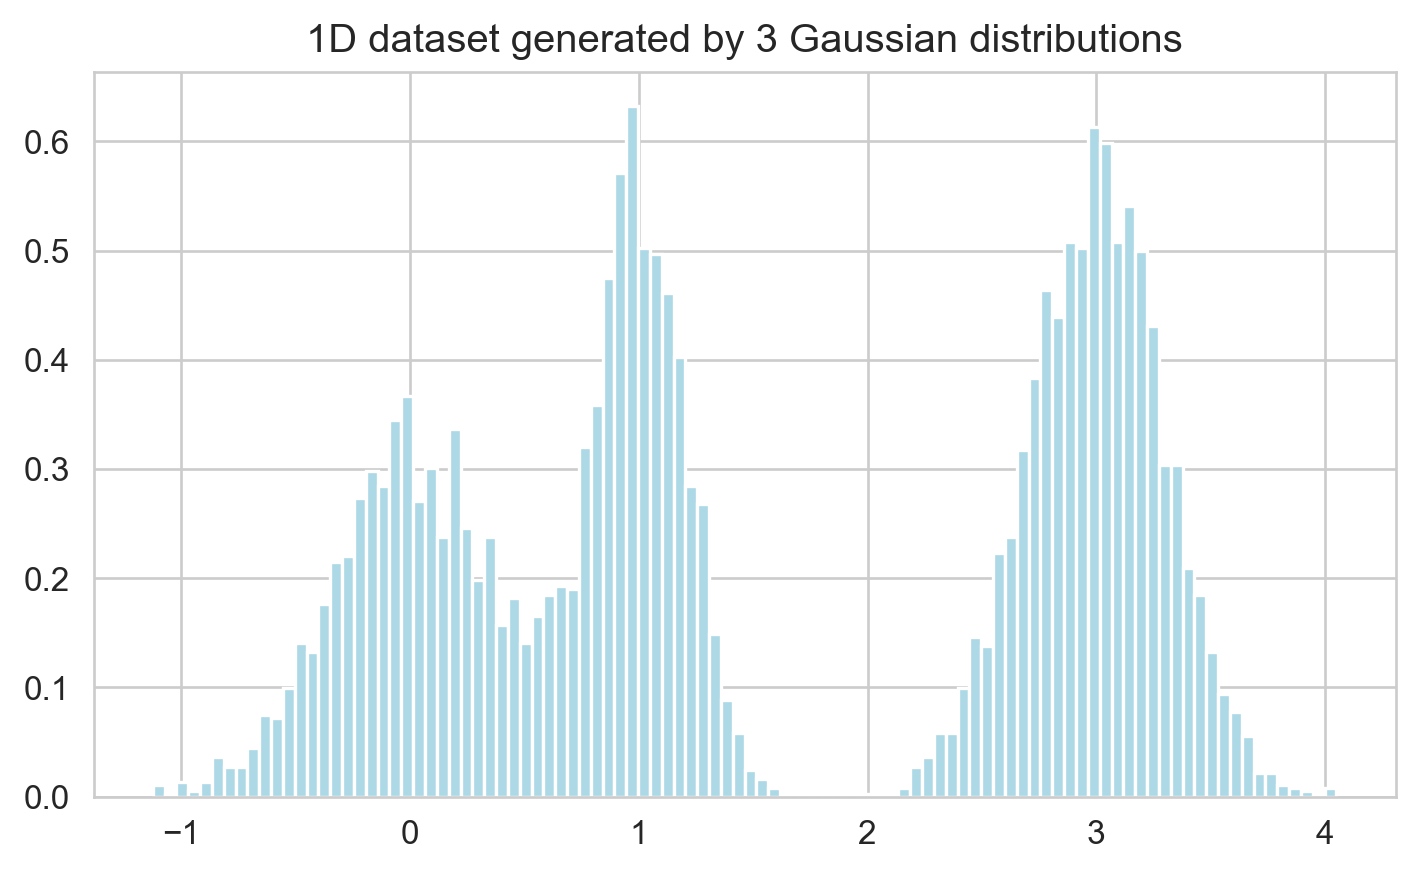

In [11]:
mu = [0, 1, 3]
std = [0.35, 0.2, 0.3]
sz = [2000, 2000, 3000]
data_1D_2gd = gen_1D_data_with_gds(mu, std, sz).reshape(-1, 1)
sns.set_style('whitegrid')
plt.hist(data_1D_2gd, bins=100, density=1, color="lightblue")
plt.title('1D dataset generated by 3 Gaussian distributions')
plt.show()

Ta sẽ so sánh khi sử dụng GMM của sklearn và GMM self-implementation cho dataset 1D đã tạo ra ở trên.

Sử dụng GMM của thư viện sklearn
Initialization 0
Initialization converged: True	 time lapse 0.03763s	 ll -1.17712
Time of GMM sklearn: 0.04087510000000005
Gaussian distribution 1: Mean: -0.01992266077202873, Std: 0.3420217727972216
Gaussian distribution 2: Mean: 2.9988712012251484, Std: 0.300443254068589
Gaussian distribution 3: Mean: 0.9895674705059191, Std: 0.21068086610246434


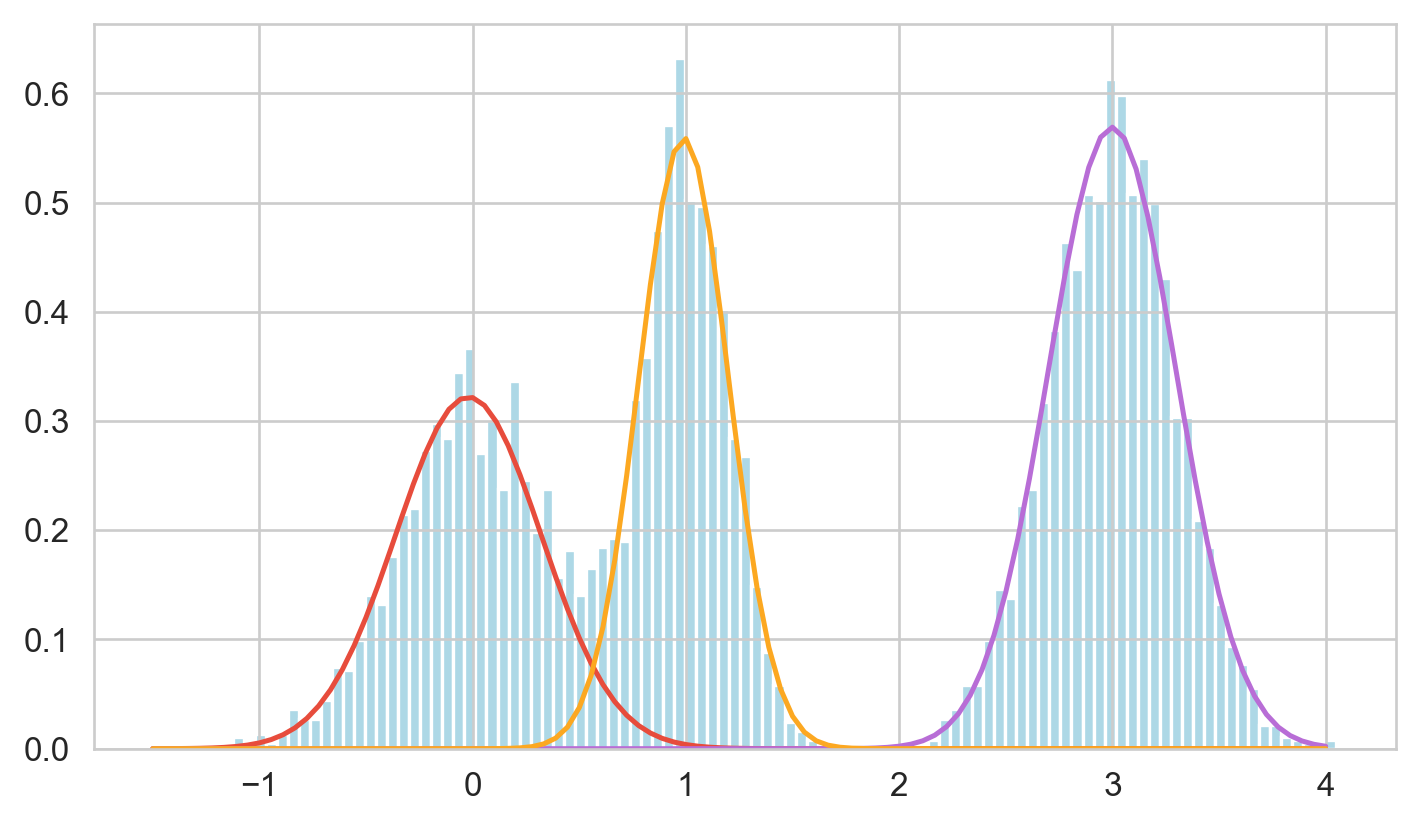

In [12]:
print('Sử dụng GMM của thư viện sklearn')
gmm = GaussianMixture(n_components=3, verbose=2, random_state=42)
start = timeit.default_timer()
gmm.fit(data_1D_2gd)
stop = timeit.default_timer()
print('Time of GMM sklearn:', stop - start)  
sns.set_style('whitegrid')
plt.hist(data_1D_2gd, bins=100, density=1, color="lightblue", zorder=0)
x_axis = np.linspace(-1.5, 4.0, 100)
for i in range(3):
    plt.plot(x_axis, gmm.weights_[i] * stats.norm.pdf(x_axis, gmm.means_[i, 0], np.sqrt(gmm.covariances_[i, 0])[0]), linestyle='solid')
    print("Gaussian distribution {}: Mean: {}, Std: {}".format(i + 1, gmm.means_[i, 0], np.sqrt(gmm.covariances_[i, 0])[0]))
plt.show()

Sử dụng GMM self-implementation
Epoch:  1 Likelihood:  -11865.962132314118
Epoch:  2 Likelihood:  -10281.275214633966
Epoch:  3 Likelihood:  -9180.137773066937
Epoch:  4 Likelihood:  -8974.358073136847
Epoch:  5 Likelihood:  -8919.542562558174
Epoch:  6 Likelihood:  -8900.164723956495
Epoch:  7 Likelihood:  -8894.413949393474
Epoch:  8 Likelihood:  -8892.216554810351
Epoch:  9 Likelihood:  -8890.667500653439
Epoch:  10 Likelihood:  -8888.993512291567
Epoch:  11 Likelihood:  -8886.91395202914
Epoch:  12 Likelihood:  -8884.216009201267
Epoch:  13 Likelihood:  -8880.623388283313
Epoch:  14 Likelihood:  -8875.710930404806
Epoch:  15 Likelihood:  -8868.782955741844
Epoch:  16 Likelihood:  -8858.649065661499
Epoch:  17 Likelihood:  -8843.185572864277
Epoch:  18 Likelihood:  -8818.474678388247
Epoch:  19 Likelihood:  -8777.251040853025
Epoch:  20 Likelihood:  -8707.096454024313
Epoch:  21 Likelihood:  -8593.62900211482
Epoch:  22 Likelihood:  -8444.710793669343
Epoch:  23 Likelihood:  -8319.1

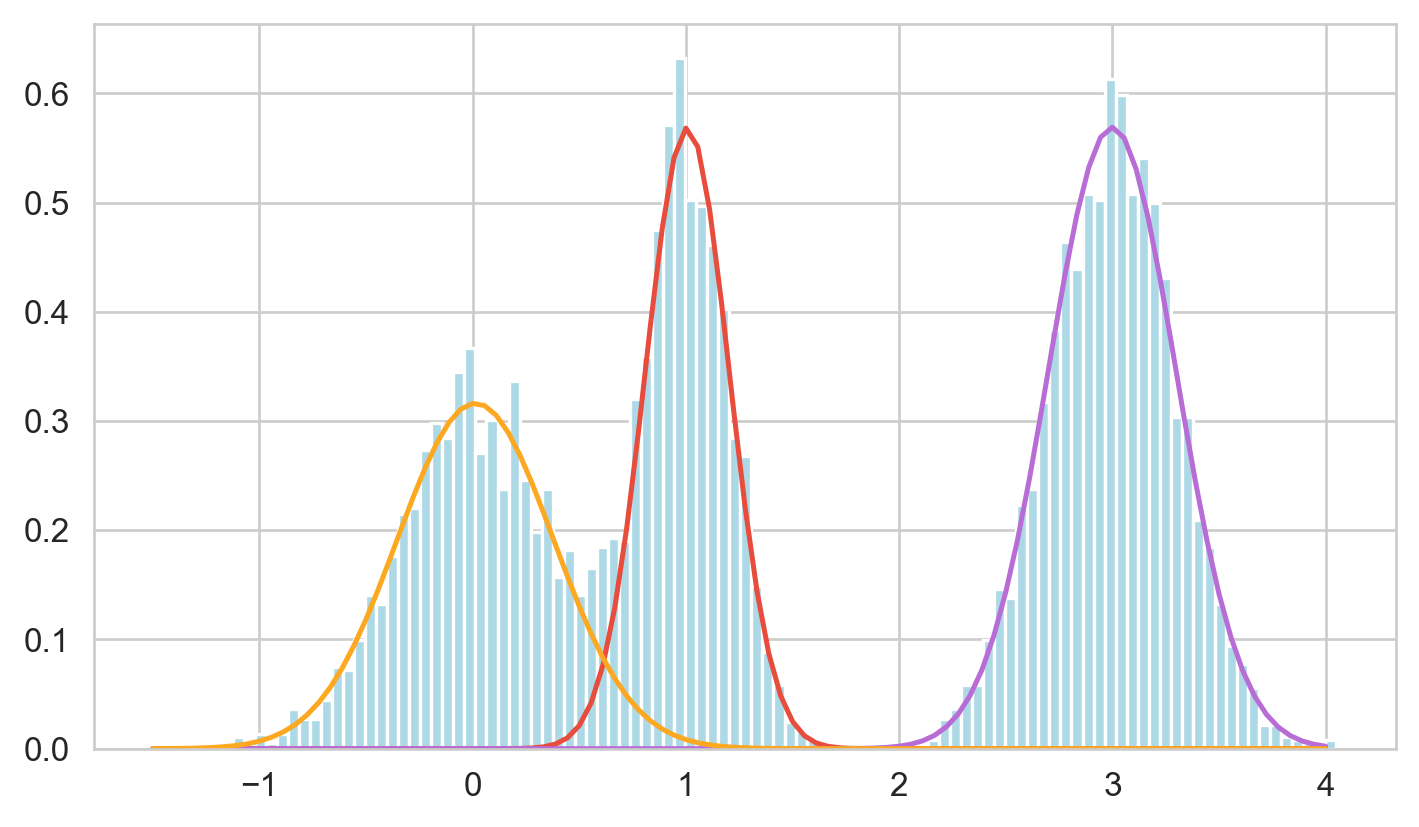

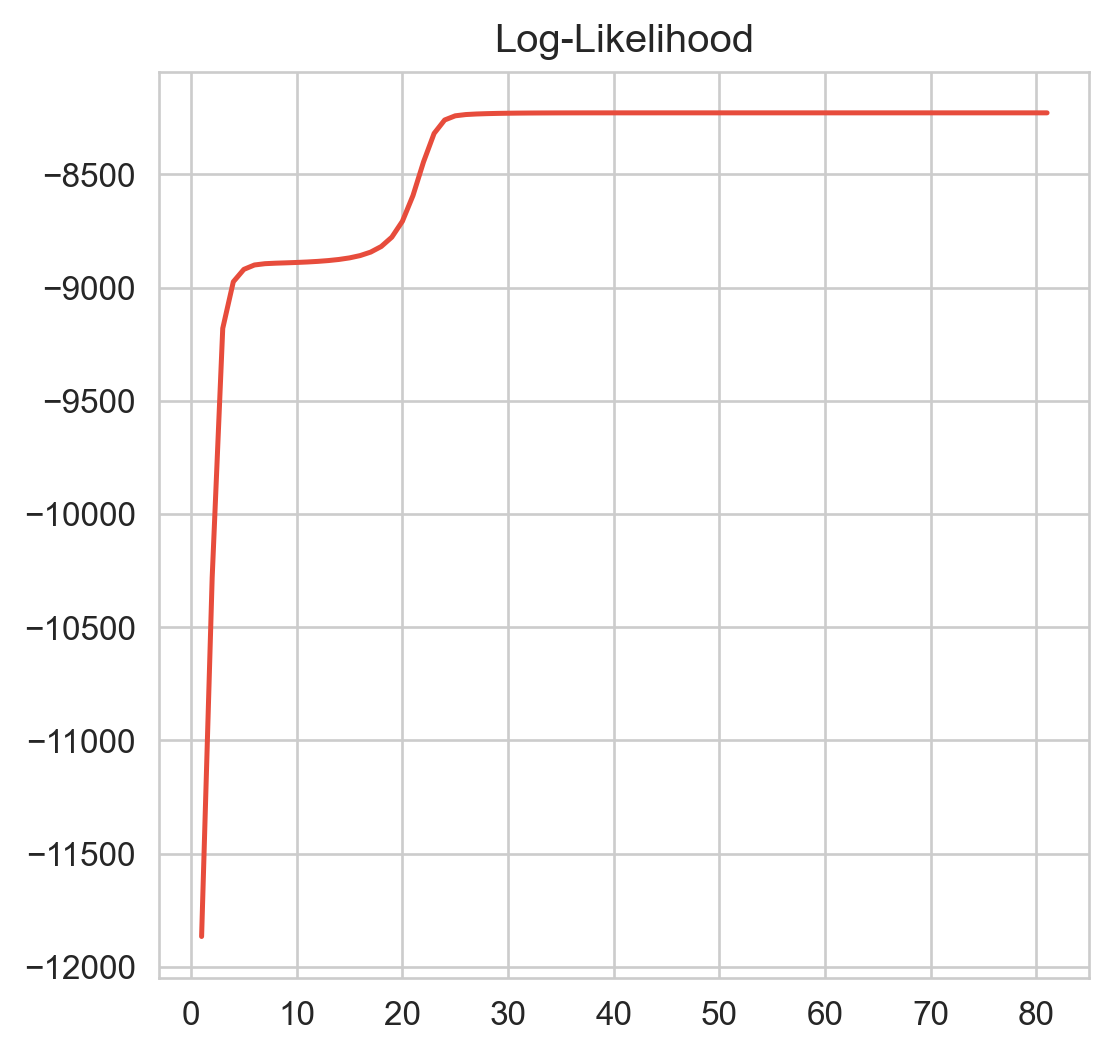

In [13]:
print('Sử dụng GMM self-implementation')
num_clusters = 3
num_epochs = 100
threshold = 1e-9
start = timeit.default_timer()
clusters, likelihoods, predict_prob = train_gmm(data_1D_2gd, num_clusters, num_epochs, threshold)
stop = timeit.default_timer()
print('Time of GMM self-implementation:', stop - start)  

plt.hist(data_1D_2gd, bins=100, density=1, color="lightblue")
x_axis = np.linspace(-1.5, 4.0, 100)
for i in range(num_clusters):
    plt.plot(x_axis, clusters[i]['phi_k'] * stats.norm.pdf(x_axis, clusters[i]['mu_k'][0], np.sqrt(clusters[i]['cov_k'][0, 0])), linestyle='solid')
    print("Gaussian distribution {}: Mean: {}, Std: {}".format(i + 1, clusters[i]['mu_k'][0], np.sqrt(clusters[i]['cov_k'][0, 0])))
plt.show()
plot_log_likelihood(likelihoods)

Ta thấy cả 2 GMM đều tìm được 2 phân phối Gaussian khá chính xác so với 2 phân phối ban đầu dùng để sinh ra data. Mặc dù vậy GMM của sklearn chạy với tốc độ nhanh gấp nhiều lần trong khi GMM khi tự implement lại thì chạy khá chậm.

Giờ ta hãy nghịch thử với phân phối điểm thi thptqg năm 2021 (xin gửi lời cảm ơn đến anh mentor VLTAnh vì data ạ :>)

In [14]:
# dt21 = pd.read_csv('thptqg2021', sep = '\t')
# %store dt21
%store -r dt21

In [15]:
dt21.head()
dt21.columns.values[4:]

array(['Toán', 'Văn', 'Lý', 'Hoá', 'Sinh', 'KHTN', 'Lịch Sử', 'Địa Lý',
       'GDCD', 'KHXH', 'Ngoại Ngữ'], dtype=object)

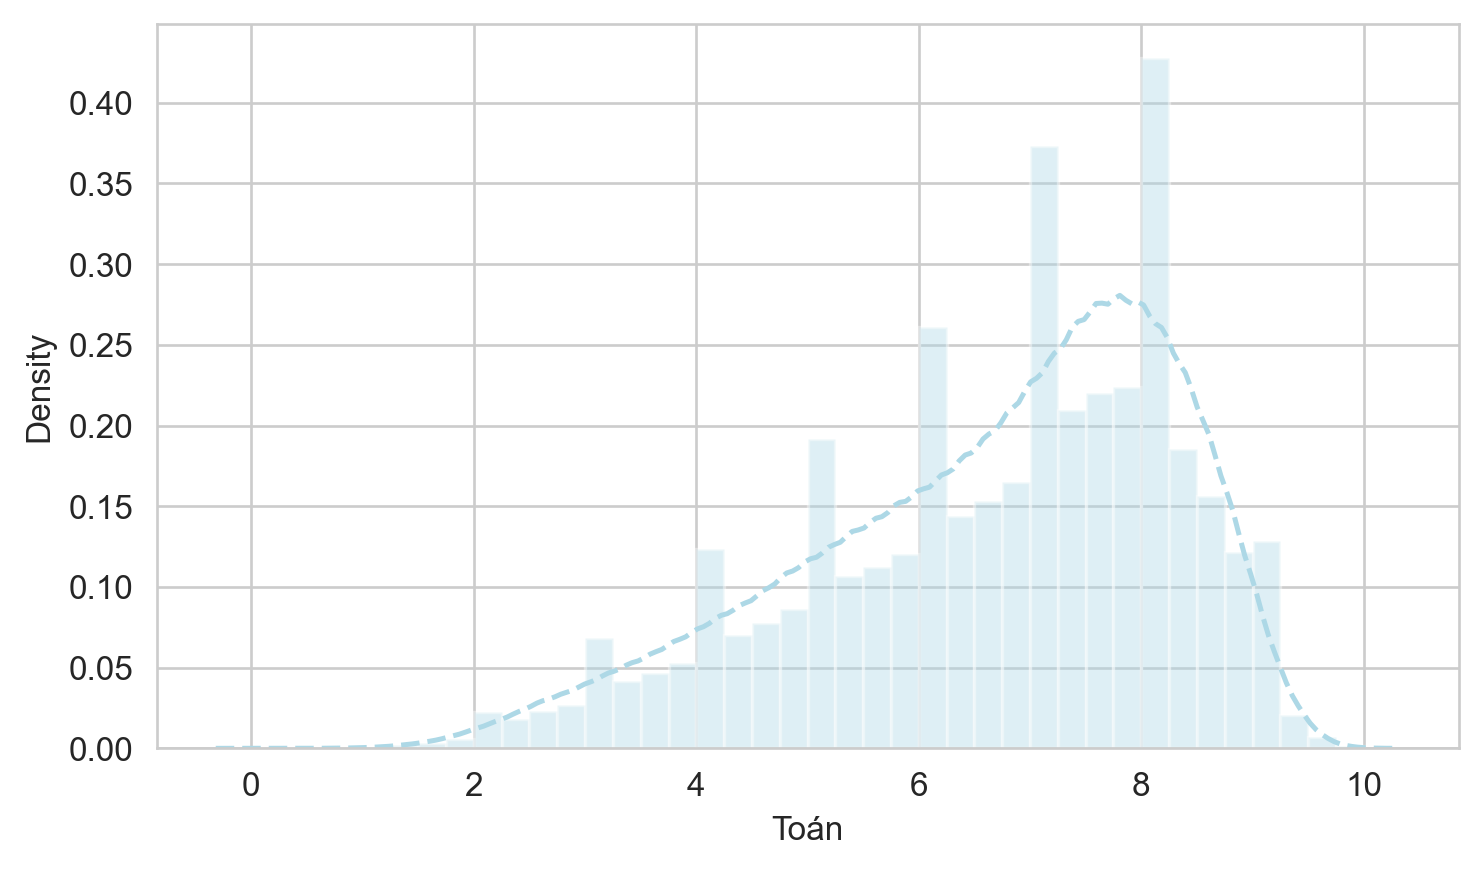

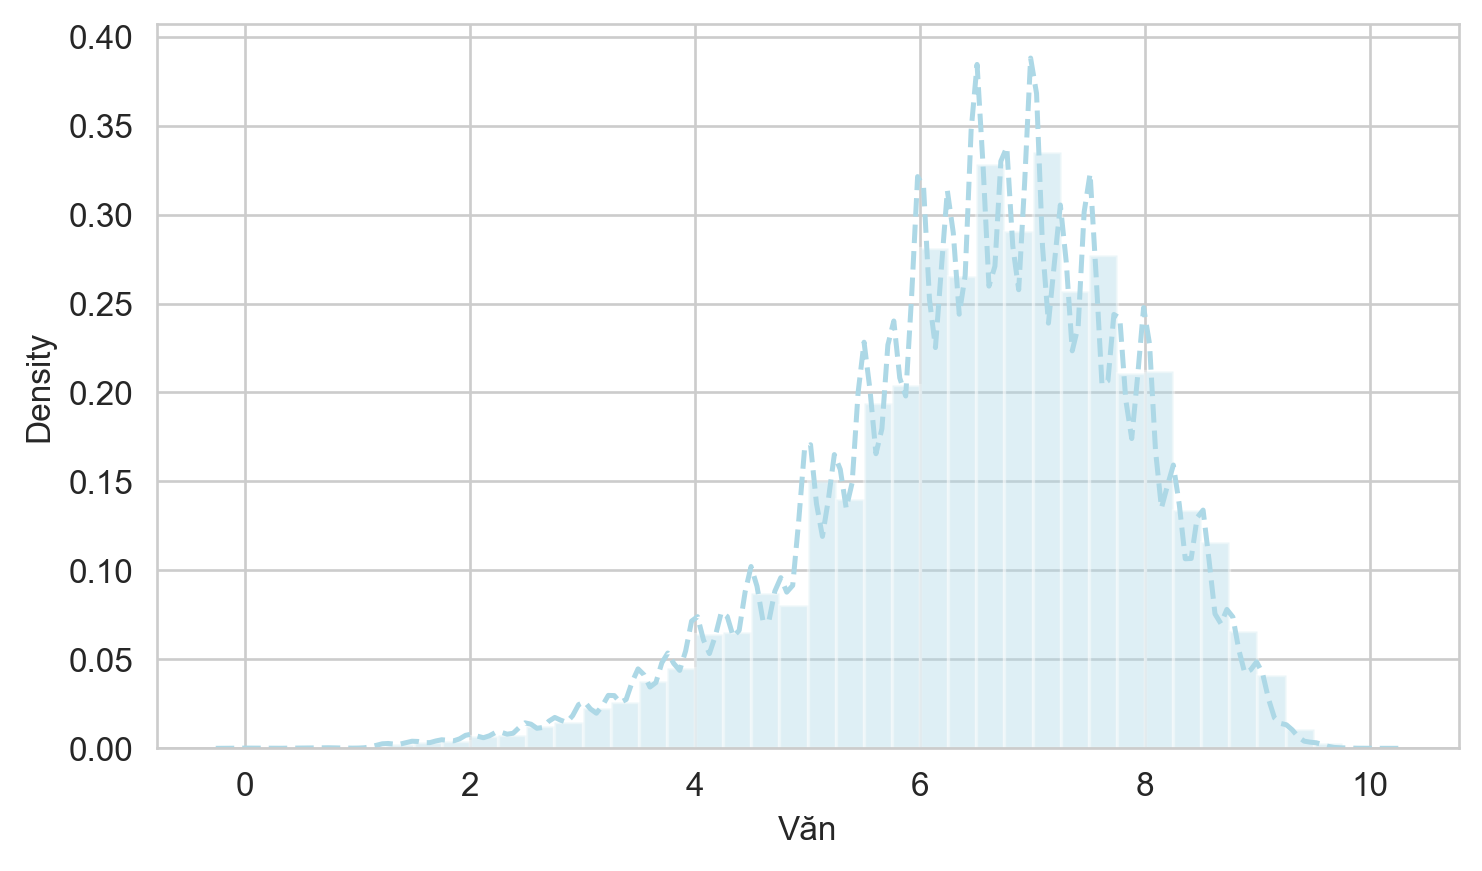

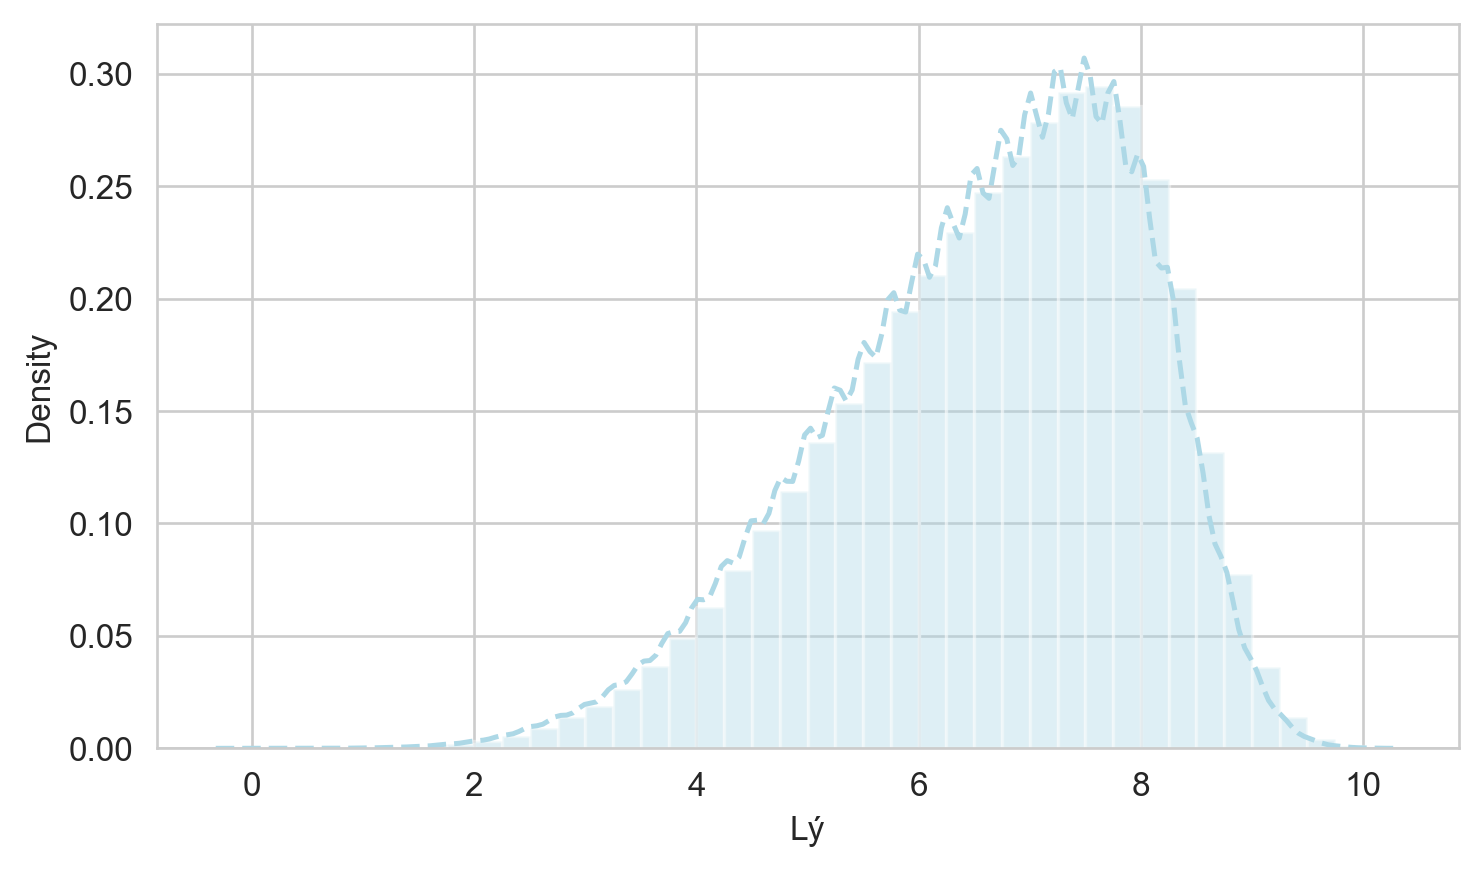

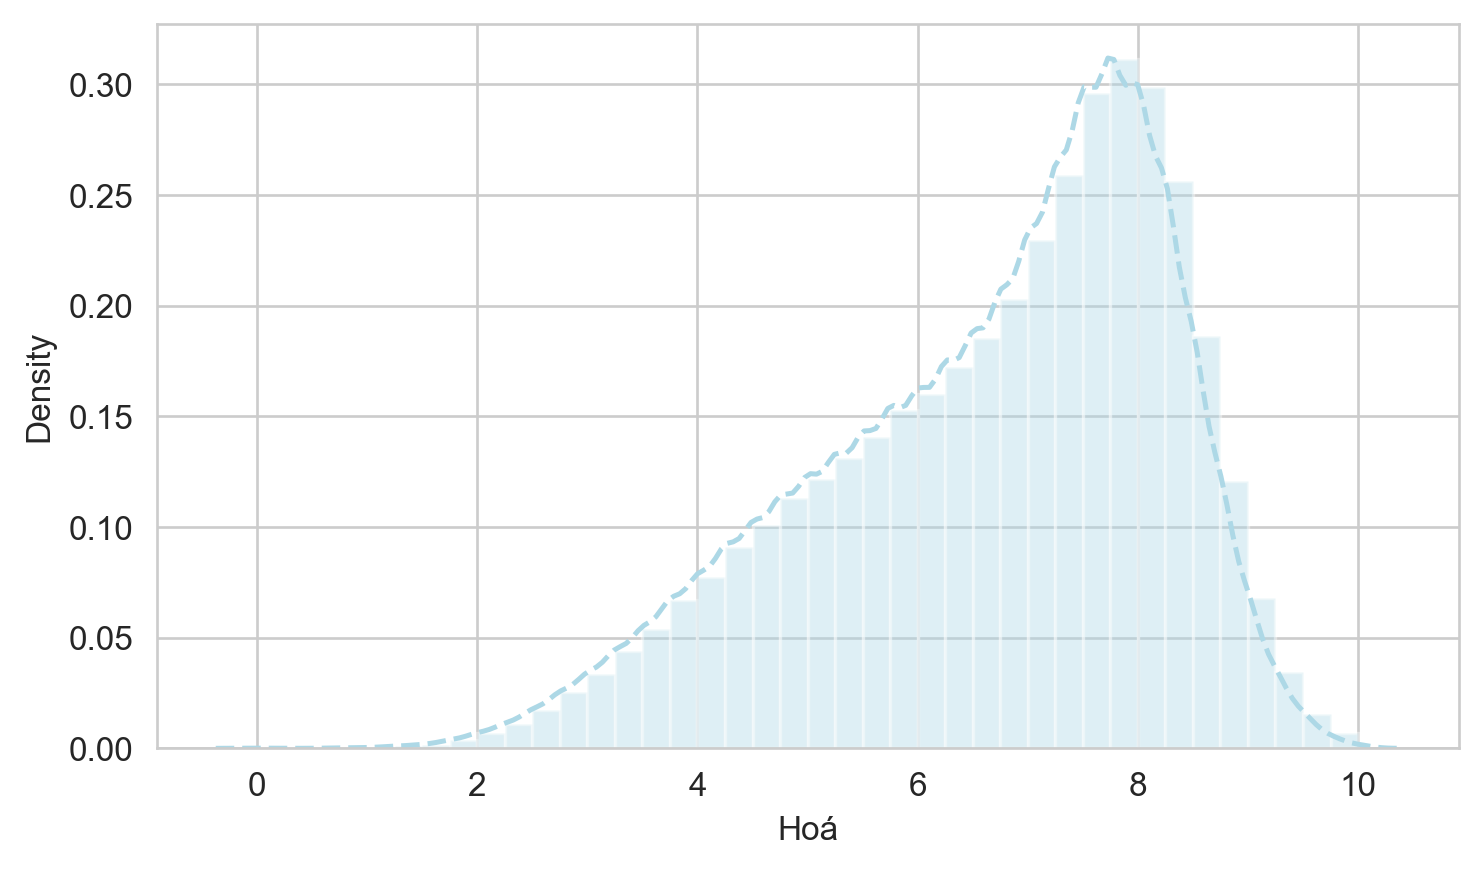

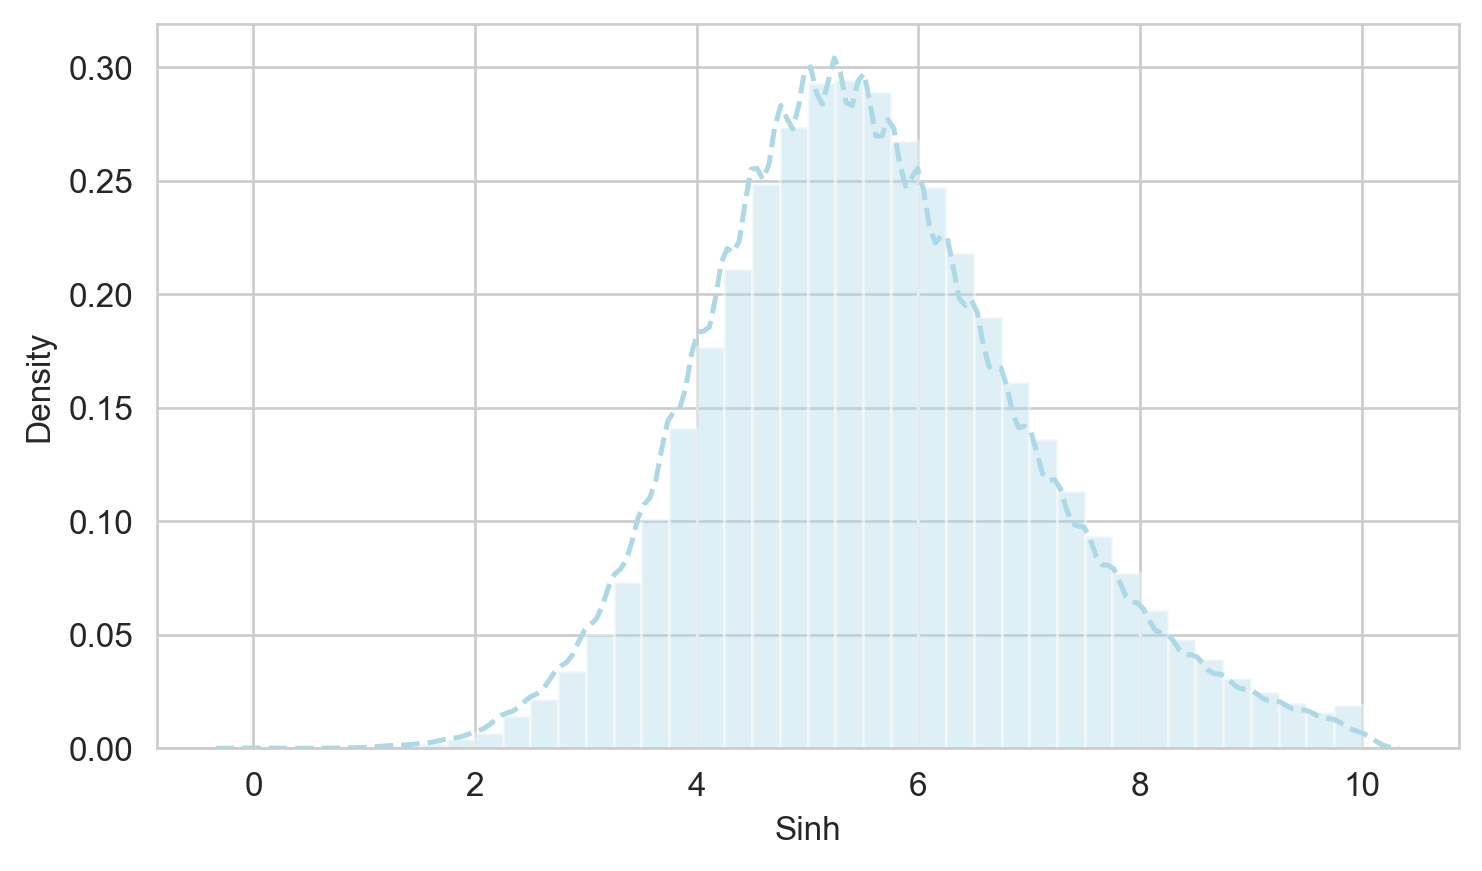

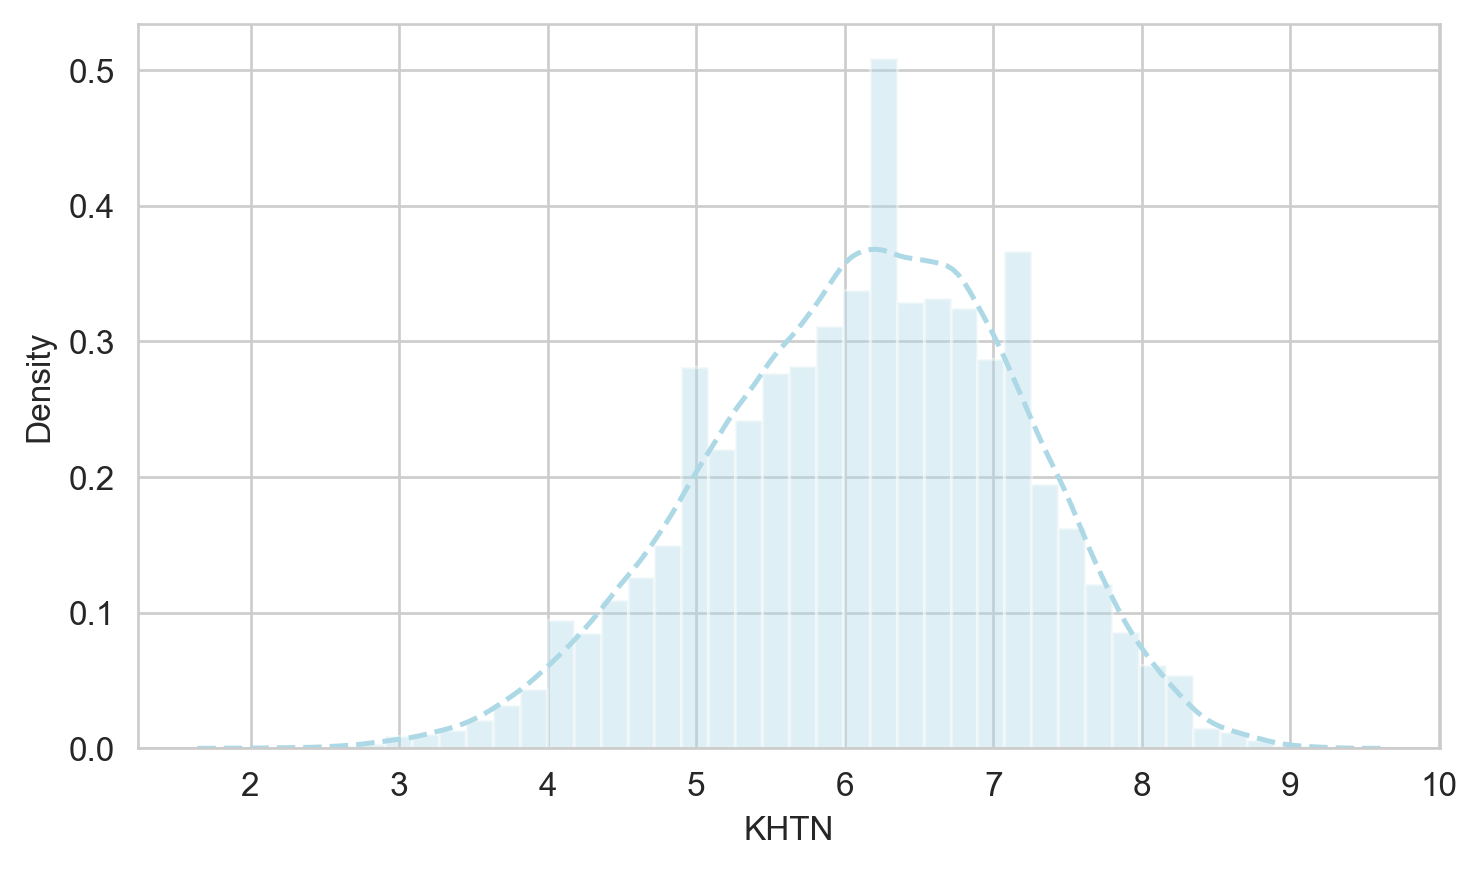

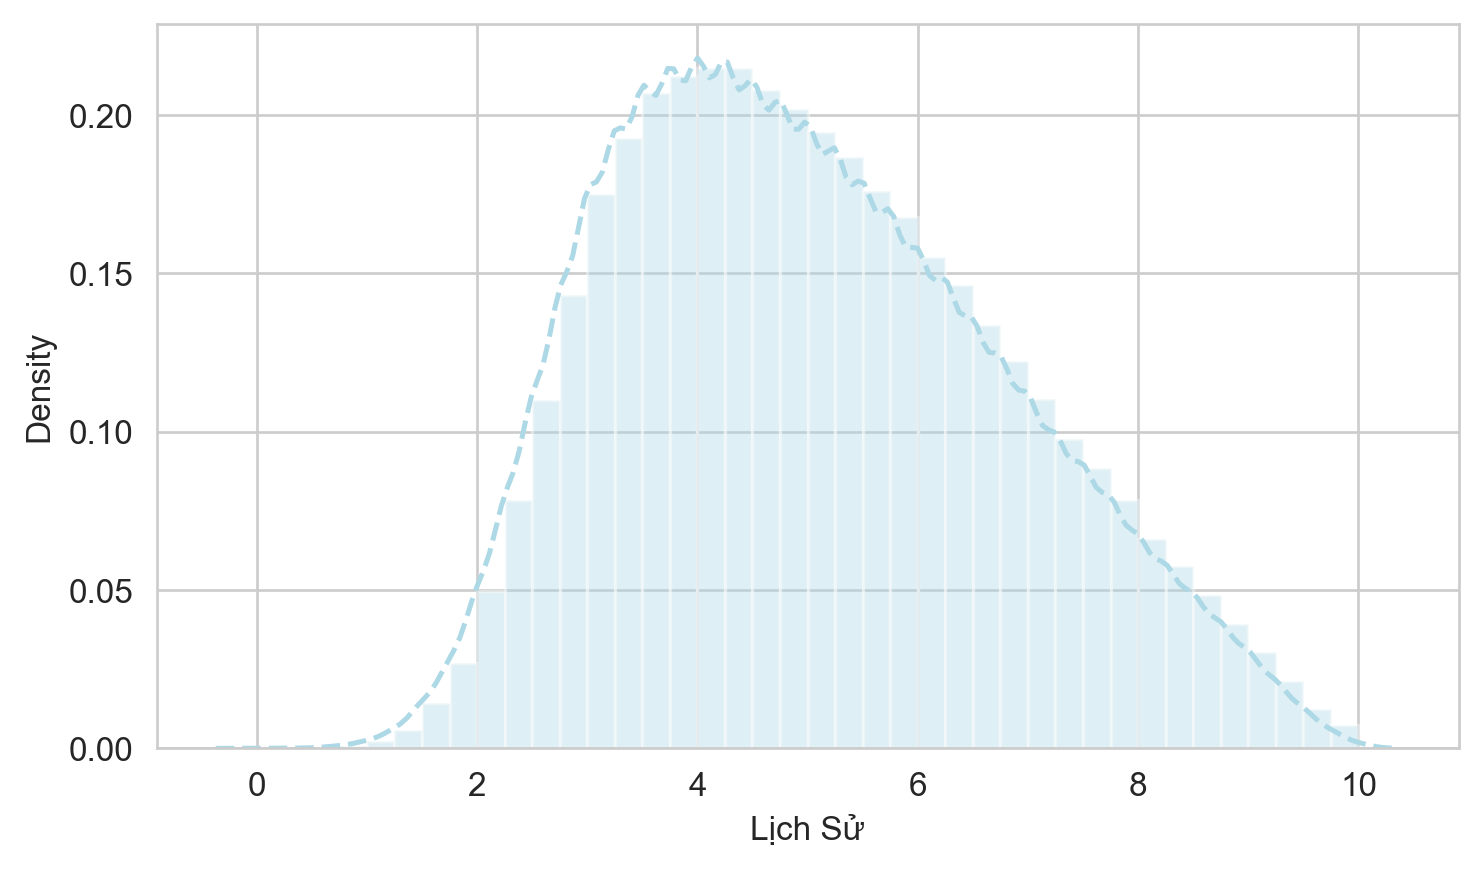

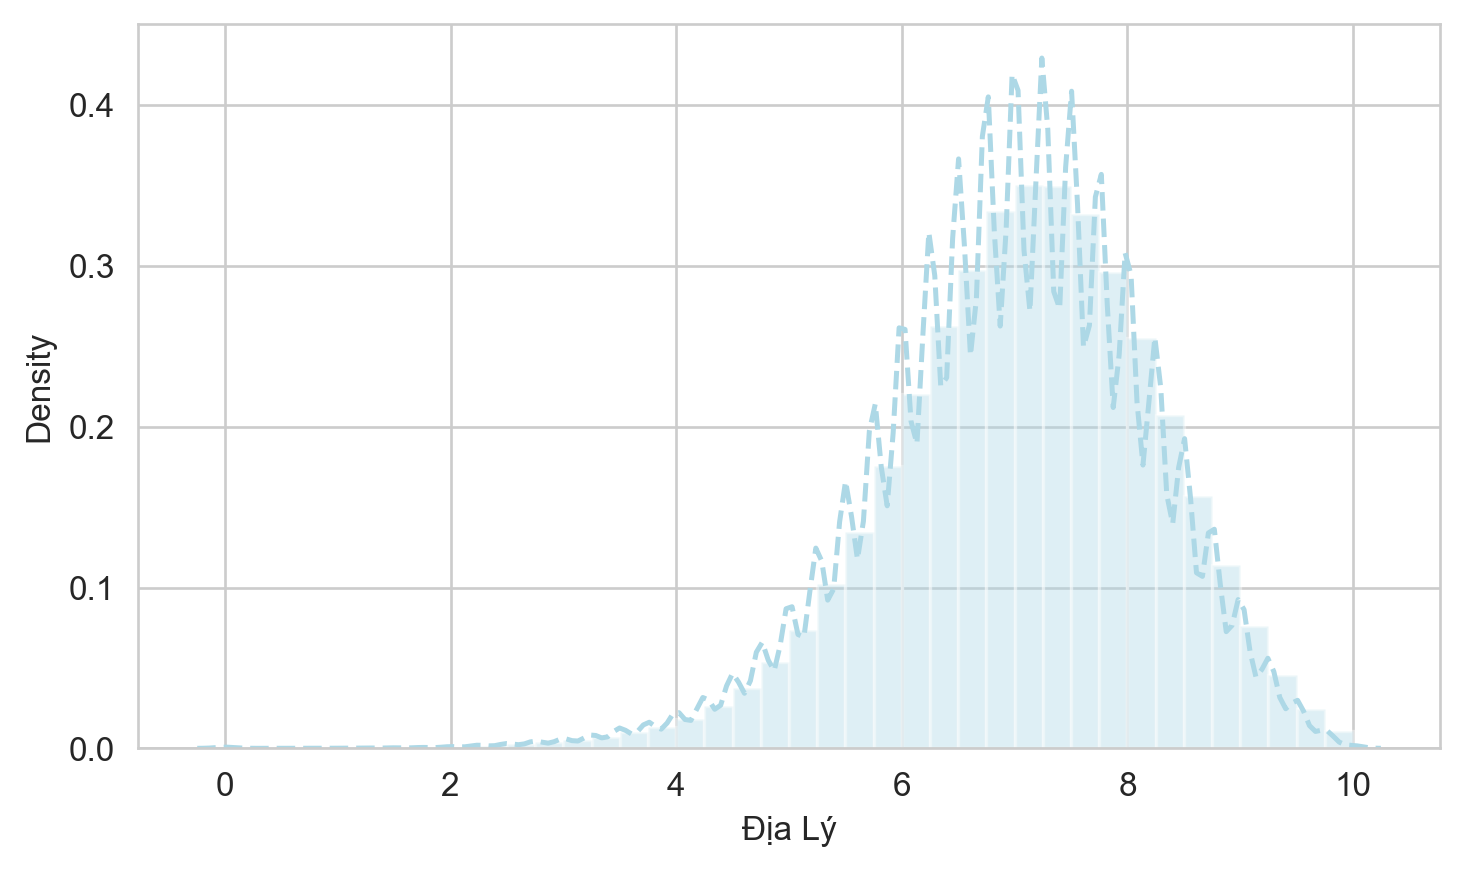

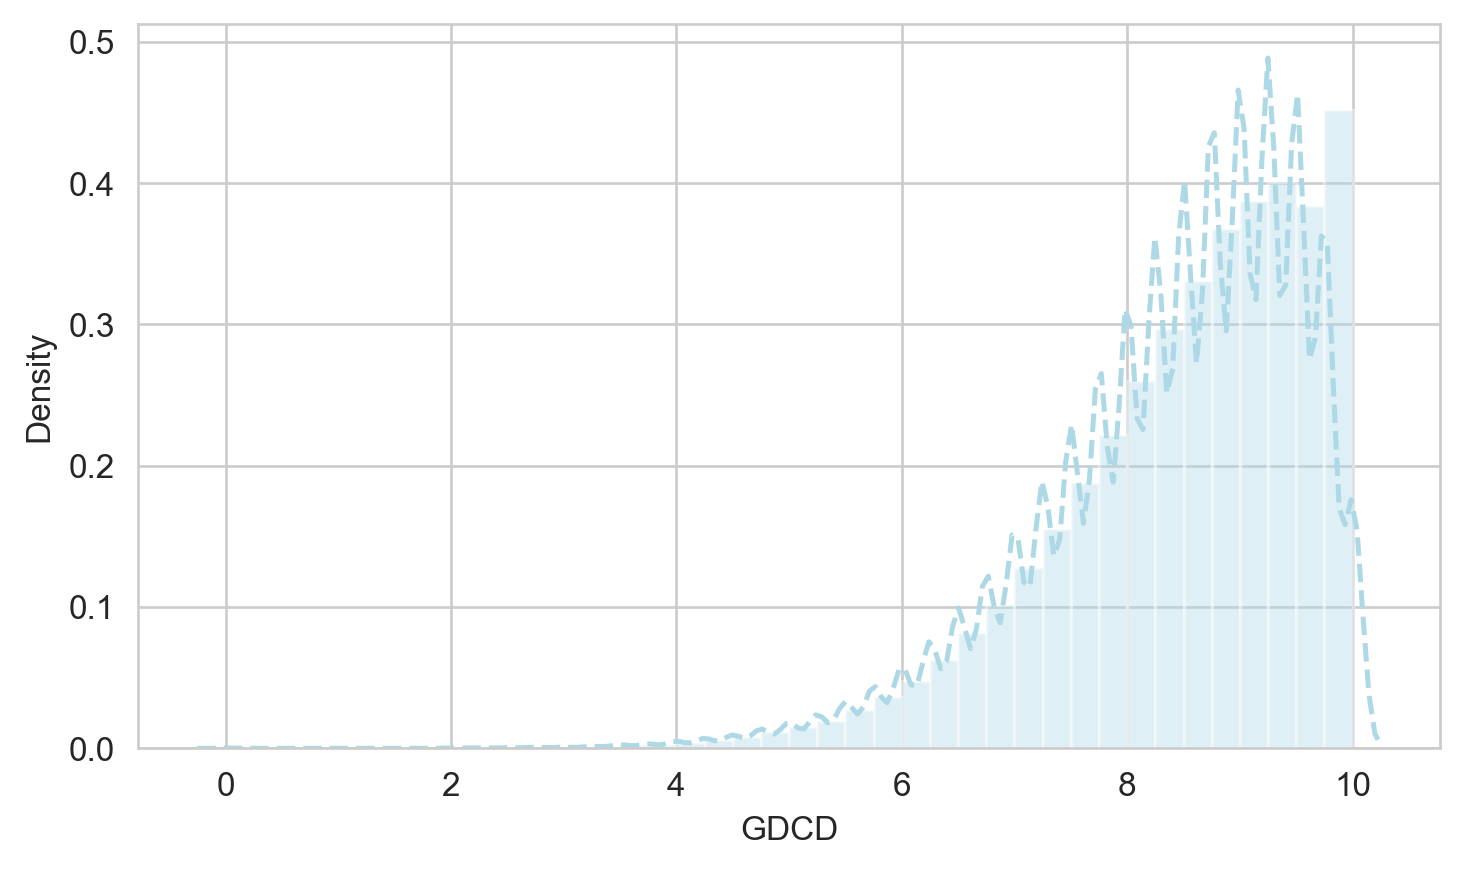

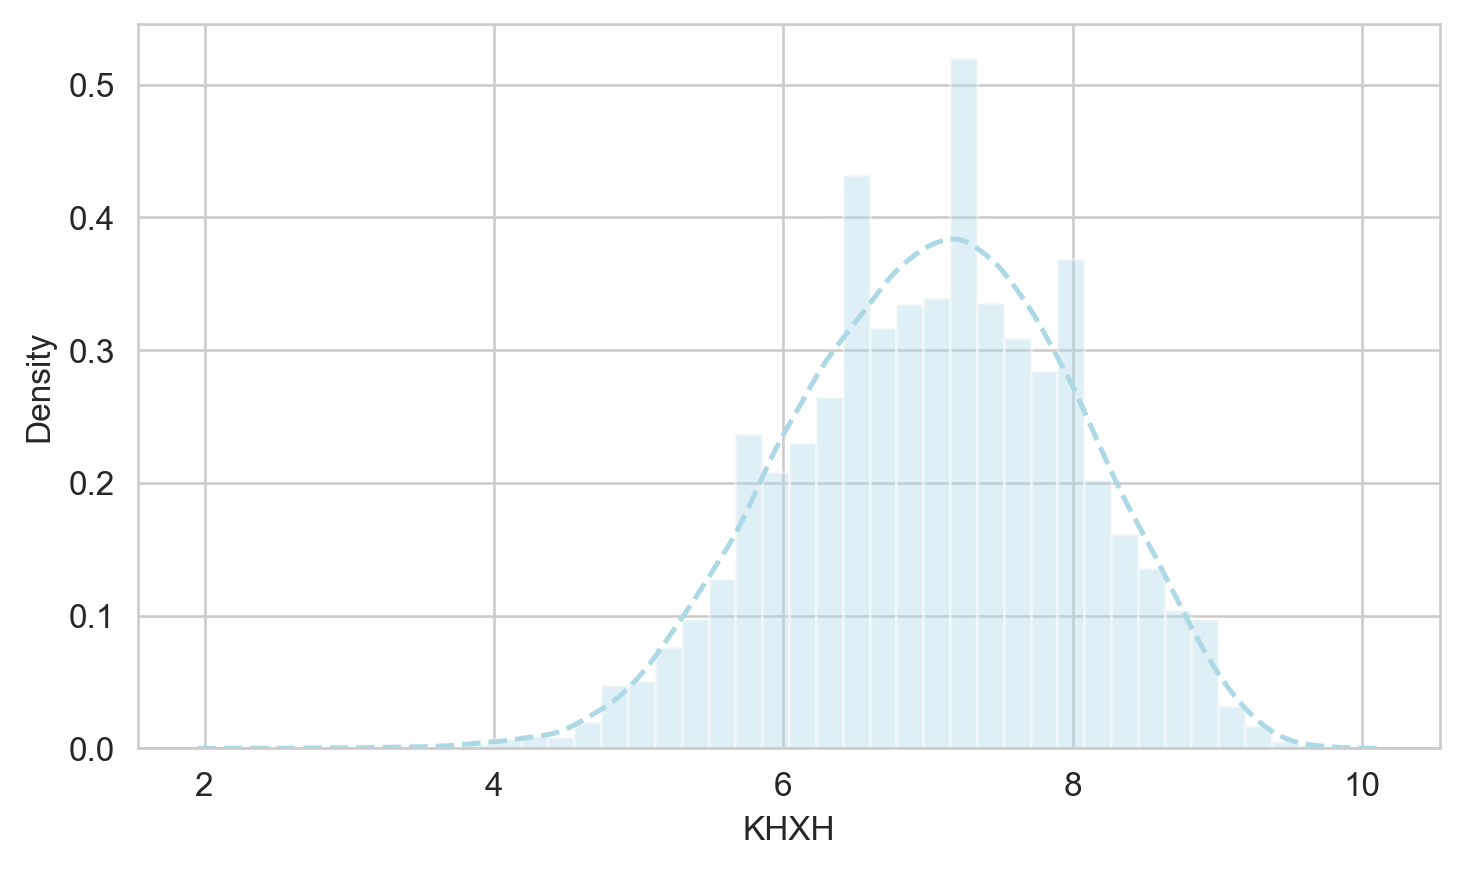

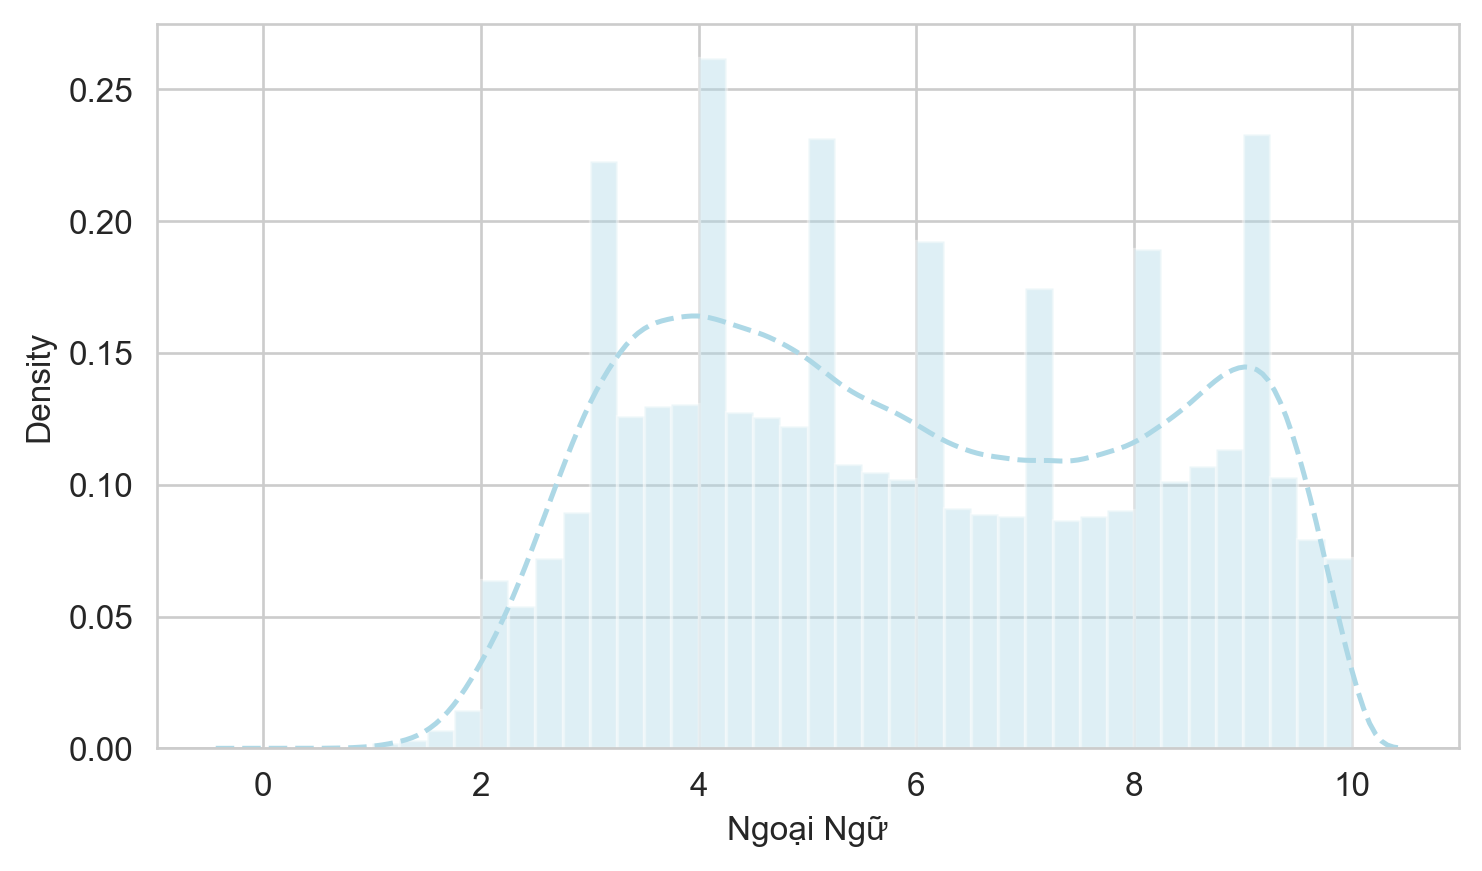

In [16]:
subjects = dt21.columns.values[4:]
i = 0;
for sub in subjects:
    i += 1
    sns.set_style('whitegrid')
    sns.distplot(pd.to_numeric(dt21[sub], errors='coerce'), bins = 40, color='lightblue')
    plt.show()

Ta sẽ thử áp dụng GMM cho phân phối điểm môn Ngoại Ngữ (vì là môn duy nhất có 2 đỉnh)

Sử dụng GMM của thư viện sklearn
Initialization 0
Initialization converged: True	 time lapse 0.81330s	 ll -2.12194
Time of GMM sklearn: 0.9285126999999989
Gaussian distribution 1: Mean: 4.263676305632633, Std: 1.197547321924117
Gaussian distribution 2: Mean: 8.034974117926646, Std: 1.1470684546266454


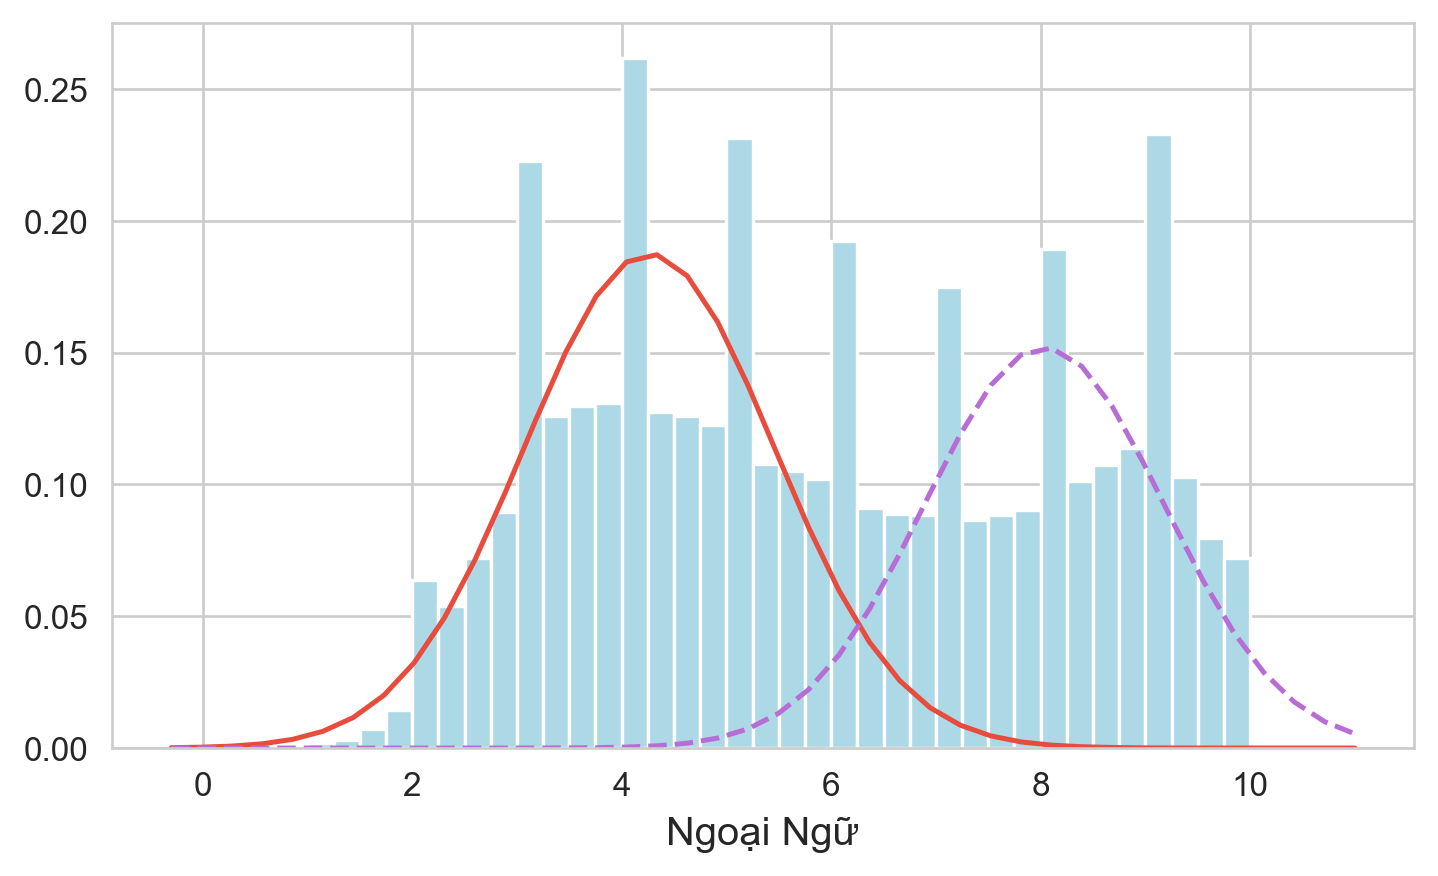

In [17]:
print('Sử dụng GMM của thư viện sklearn')
dtNN = pd.to_numeric(dt21['Ngoại Ngữ'], errors='coerce').values;
dtNN = dtNN[~np.isnan(dtNN)].reshape(-1, 1)
gmm = GaussianMixture(n_components=2, verbose=2, random_state=42)
start = timeit.default_timer()
gmm.fit(dtNN)
stop = timeit.default_timer()
print('Time of GMM sklearn:', stop - start)  
sns.set_style('whitegrid')

plt.hist(dtNN, bins=40, density=1, color="lightblue")
x_axis = np.linspace(-0.3, 11, 40)
for i in range(2):
    plt.plot(x_axis, gmm.weights_[i] * stats.norm.pdf(x_axis, gmm.means_[i, 0], np.sqrt(gmm.covariances_[i, 0])))
    print("Gaussian distribution {}: Mean: {}, Std: {}".format(i + 1, gmm.means_[i, 0], np.sqrt(gmm.covariances_[i, 0])[0]))
plt.title('Ngoại Ngữ', y=-0.16)
plt.show()

Sử dụng GMM self-implementation
Epoch:  1 Likelihood:  -1746951.2355478865
Epoch:  2 Likelihood:  -1725972.1318372046
Epoch:  3 Likelihood:  -1724715.1047002564
Epoch:  4 Likelihood:  -1724383.4589530844
Epoch:  5 Likelihood:  -1724159.8346043138
Epoch:  6 Likelihood:  -1723957.3190605552
Epoch:  7 Likelihood:  -1723764.9669680912
Epoch:  8 Likelihood:  -1723581.2248372643
Epoch:  9 Likelihood:  -1723405.7125900832
Epoch:  10 Likelihood:  -1723238.1759703995
Epoch:  11 Likelihood:  -1723078.3644407776
Epoch:  12 Likelihood:  -1722926.0227745199
Epoch:  13 Likelihood:  -1722780.8934926938
Epoch:  14 Likelihood:  -1722642.7190161273
Epoch:  15 Likelihood:  -1722511.2430895753
Epoch:  16 Likelihood:  -1722386.2118073273
Epoch:  17 Likelihood:  -1722267.374426597
Epoch:  18 Likelihood:  -1722154.4840471274
Epoch:  19 Likelihood:  -1722047.298190101
Epoch:  20 Likelihood:  -1721945.579291712
Epoch:  21 Likelihood:  -1721849.0951209345
Epoch:  22 Likelihood:  -1721757.6191283755
Epoch:  23 L

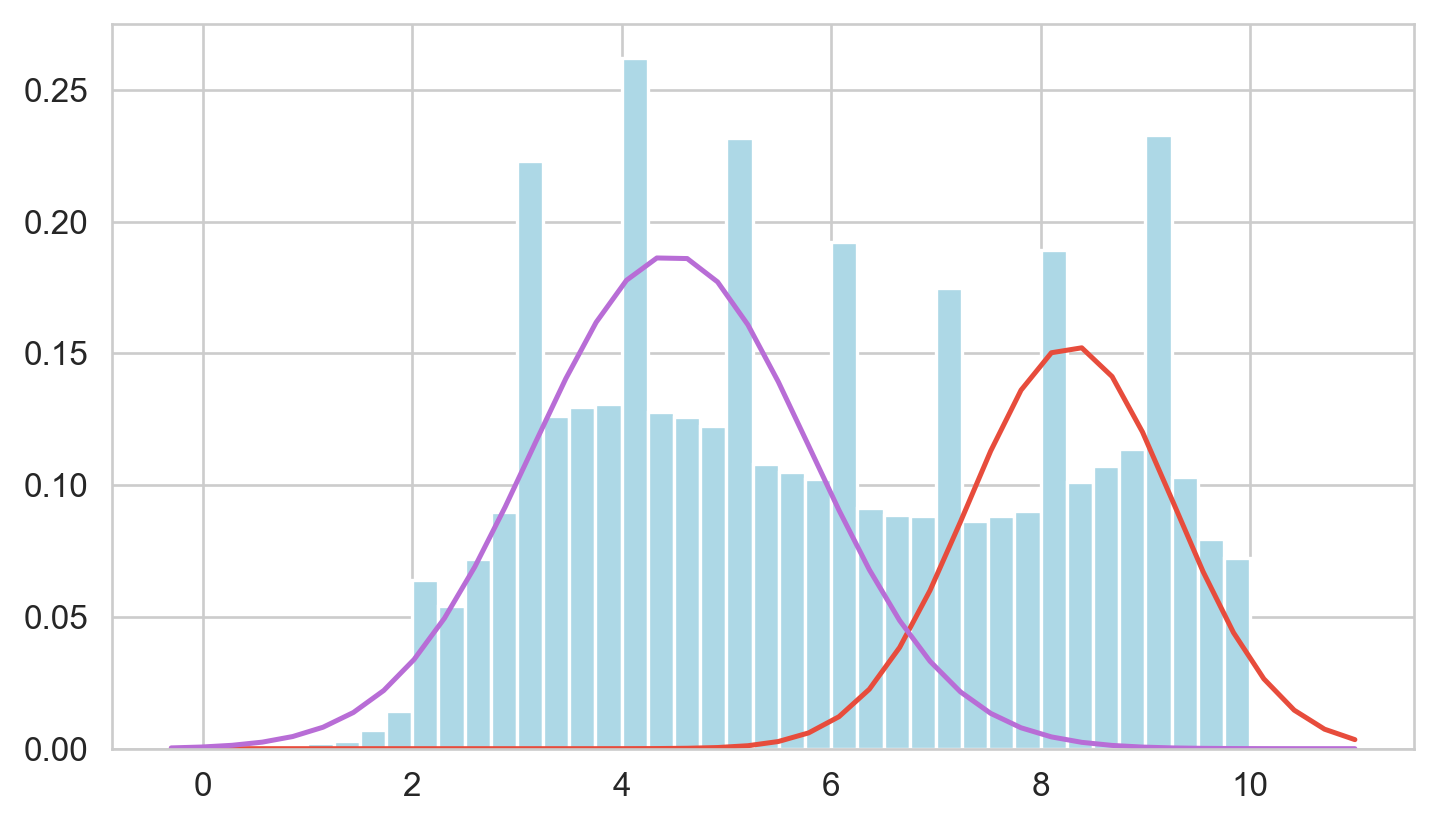

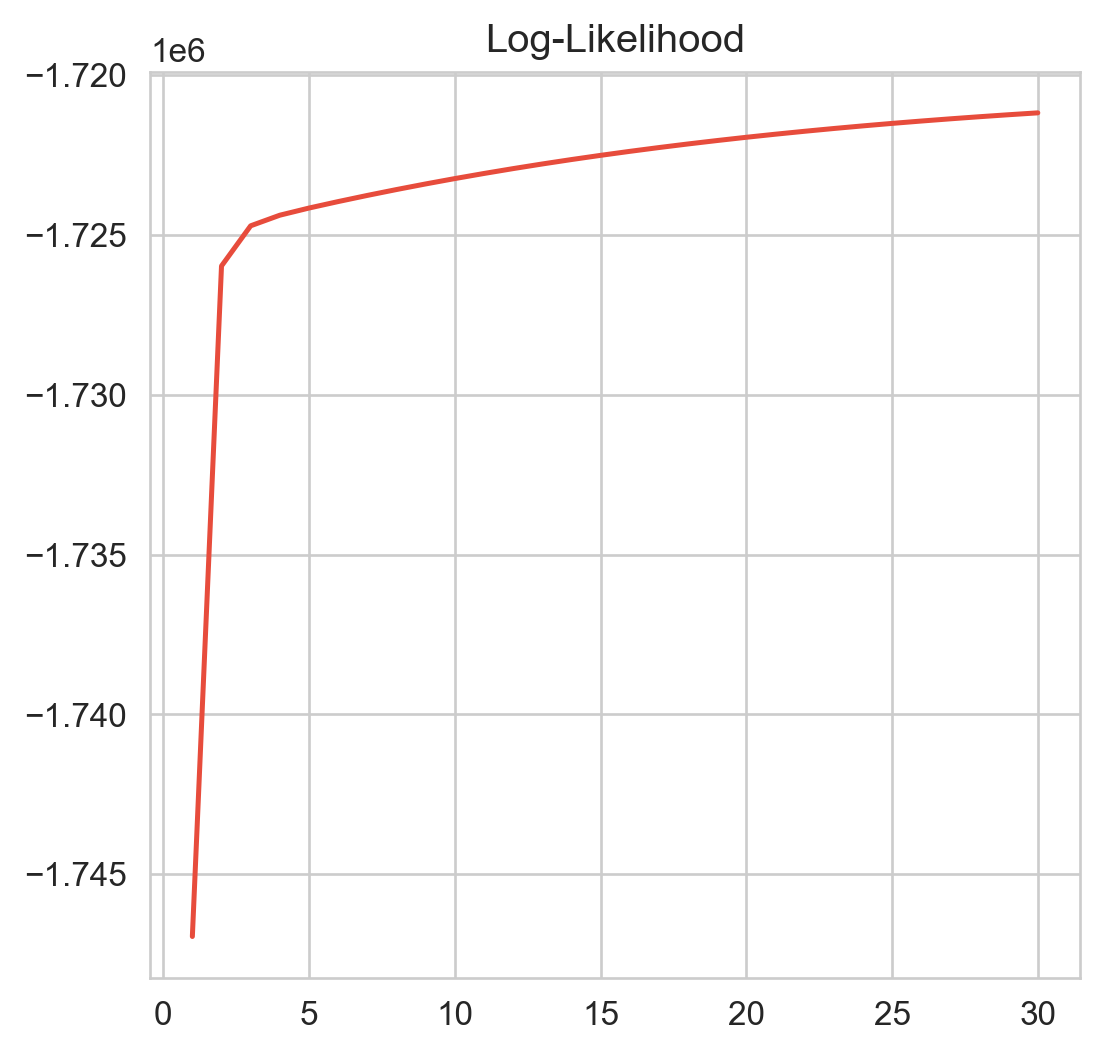

In [18]:
print('Sử dụng GMM self-implementation')
num_clusters = 2
num_epochs = 30
threshold = 1e-9
start = timeit.default_timer()
clusters, likelihoods, predict_prob = train_gmm(dtNN, num_clusters, num_epochs, threshold)
stop = timeit.default_timer()
print('Time of GMM self-implementation:', stop - start)  
sns.set_style('whitegrid')
plt.hist(dtNN, bins=40, density=1, color="lightblue")
x_axis = np.linspace(-0.3, 11.0, 40)
for i in range(num_clusters):
    plt.plot(x_axis, clusters[i]['phi_k'] * stats.norm.pdf(x_axis, clusters[i]['mu_k'][0], np.sqrt(clusters[i]['cov_k'][0, 0])), linestyle='solid')
    print("Gaussian distribution {}: Mean: {}, Std: {}".format(i + 1, clusters[i]['mu_k'][0], np.sqrt(clusters[i]['cov_k'][0, 0])))
plt.show()
plot_log_likelihood(likelihoods)

Vì số lượng lên tới hơn 800000 học sinh, GMM self-implementation chạy chậm hơn nhiều so với thư viện sklearn.

# <a id='3'>3. GMM with 2D datasets

Ta sẽ viết 2 hàm dùng cho datasets 2D lần lượt là GMM của sklearn và GMM self-implementation

In [19]:
def gmm_sklearn_2D_dataset(X, num_clusters, label=False, square=1):
    gmm = GaussianMixture(n_components=num_clusters, verbose=2, random_state=42)
    start = timeit.default_timer()
    gmm.fit(X)
    stop = timeit.default_timer()
    print('Time of GMM sklearn:', stop - start)  
    labels = gmm.predict(X)
    plot_gmm(X, labels, gmm.means_, gmm.covariances_, gmm.weights_, square, label)

In [20]:
def gmm_2D_dataset(X, num_clusters, steps=30, num_epochs=100, threshold=1e-9):
    start = timeit.default_timer()
    clusters, likelihoods, predict_prob = train_gmm(X, num_clusters, num_epochs, threshold, steps)
    stop = timeit.default_timer()
    print('Time of GMM self-implementation:', stop - start)  
    labels = np.zeros((X.shape[0], ))
    for i in range(X.shape[0]):
        labels[i] = np.argmax(predict_prob[i])
    means_ = []
    covariances_ = []
    weights_ = []
    for cluster in clusters:
        means_.append(cluster['mu_k'])
        covariances_.append(cluster['cov_k'])
        weights_.append(cluster['phi_k'])
    plot_gmm(X, labels, means_, covariances_, weights_, 1)
    plot_log_likelihood(likelihoods)

Ta sẽ dùng sklearn.datasets để tạo ra một data **blobs** với 1000 điểm và transform các điểm thành data như bên dưới.

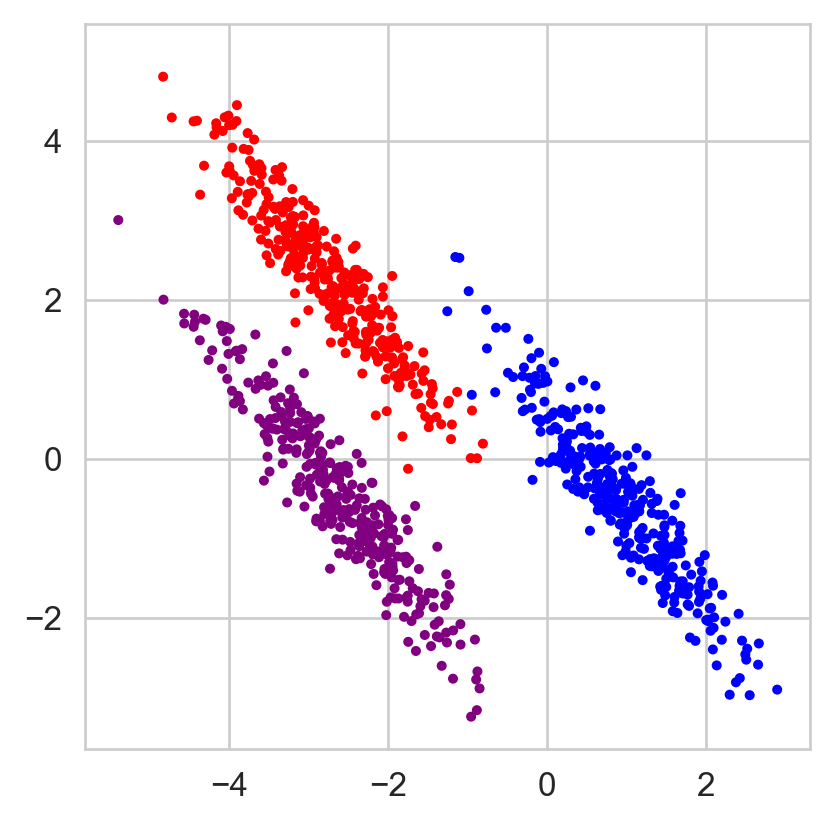

In [21]:
X, y = datasets.make_blobs(n_samples=1000, random_state=170)
transformation = [[0.6, -0.5], [-0.5, 0.9]]
X_aniso = np.dot(X, transformation)
sns.set_style('whitegrid')
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c = y, cmap=matplotlib.colors.ListedColormap(colors))
plt.axis('square')
plt.show()

Initialization 0
Initialization converged: True	 time lapse 0.01600s	 ll -2.63988
Time of GMM sklearn: 0.018035900000086258


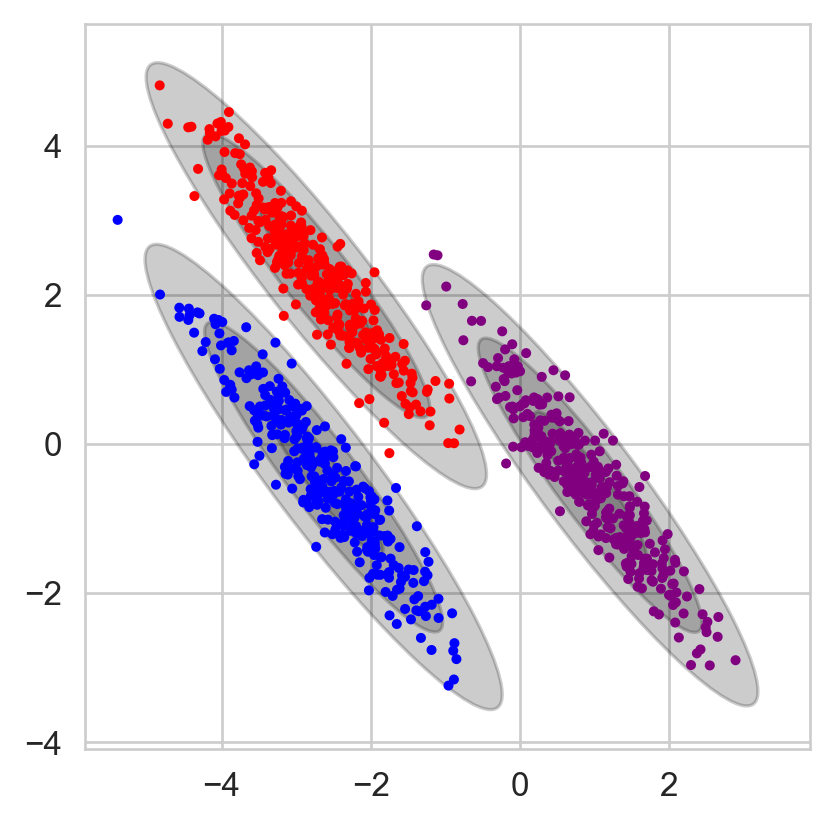

In [22]:
gmm_sklearn_2D_dataset(X_aniso, 3, 1)

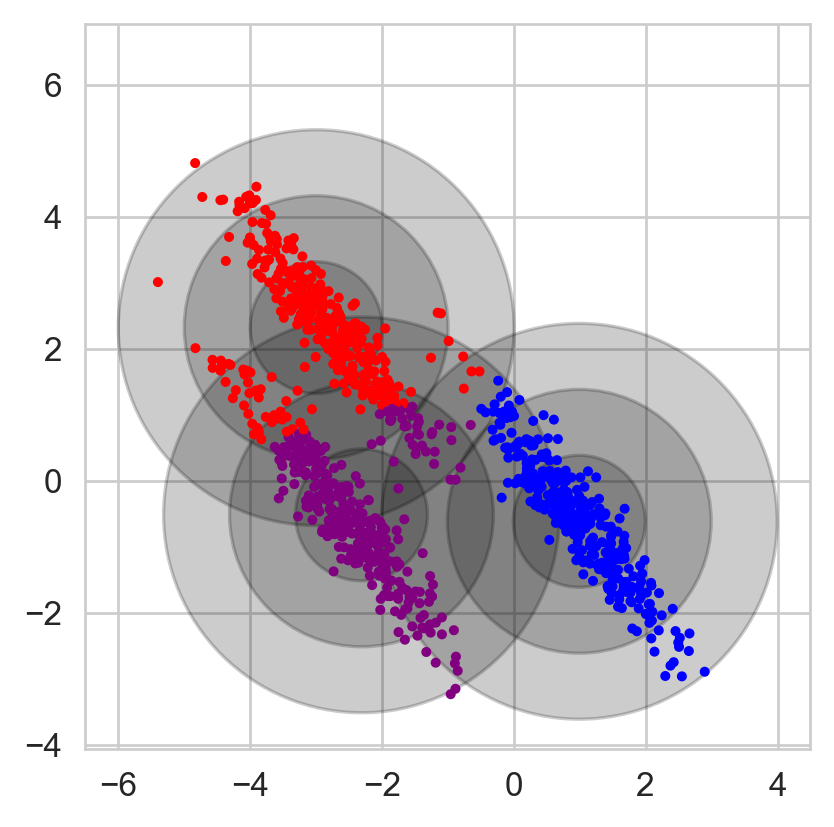

Epoch:  1 Likelihood:  -3498.697459025682


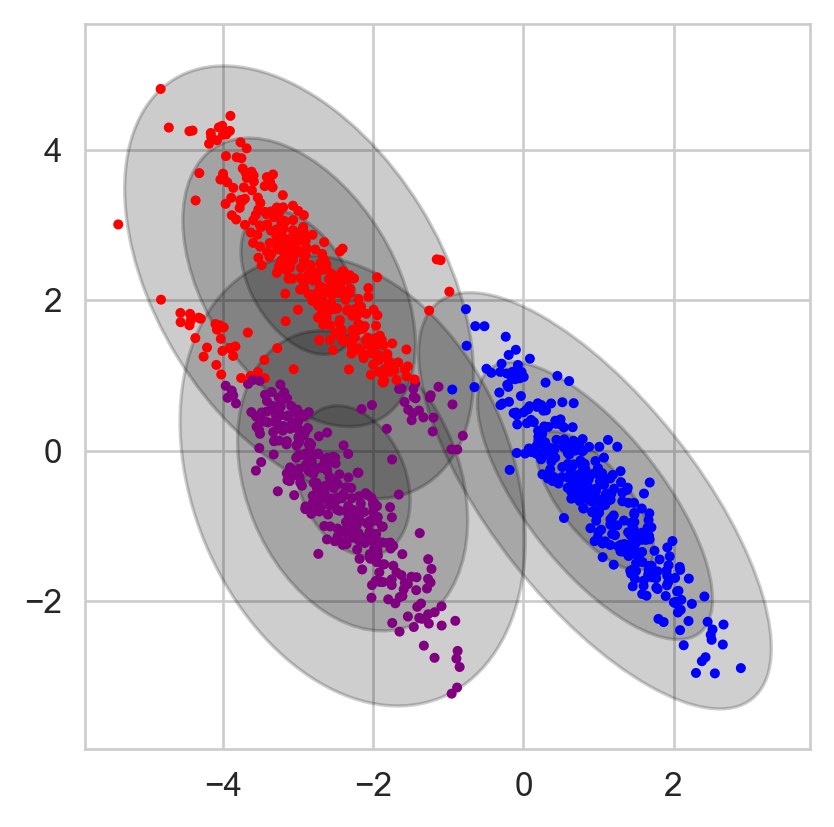

Epoch:  2 Likelihood:  -3160.627235059322


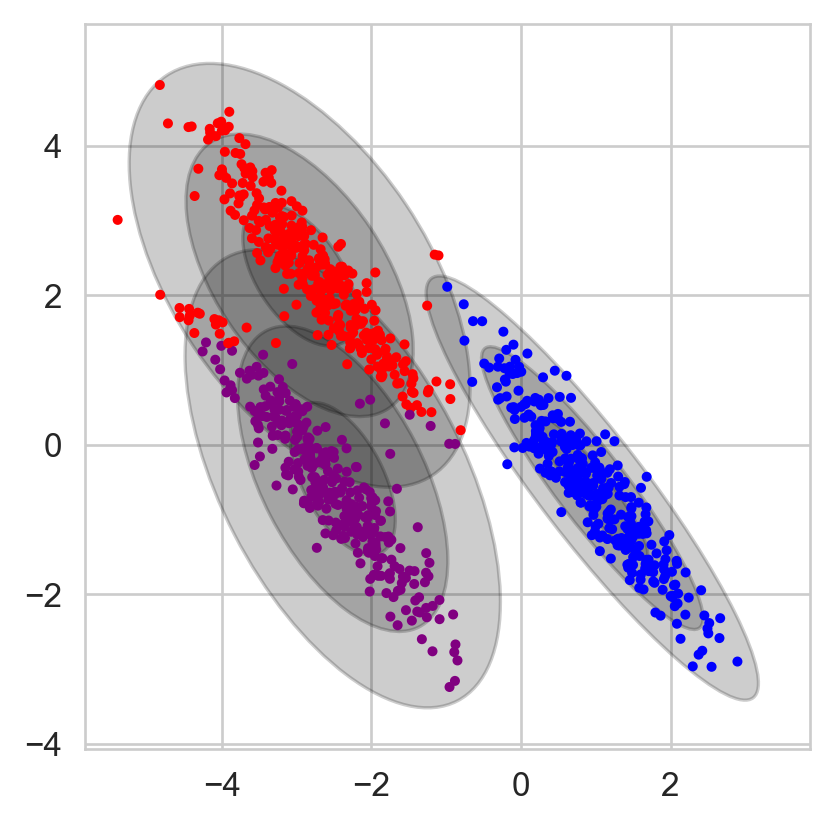

Epoch:  3 Likelihood:  -2987.1607331583236


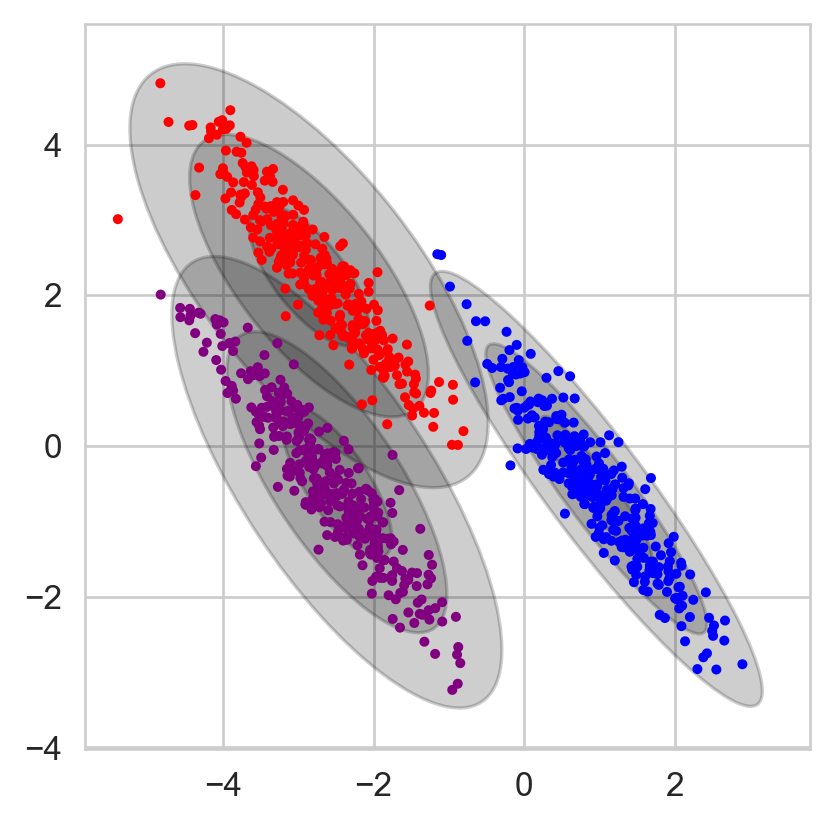

Epoch:  4 Likelihood:  -2866.975919546304


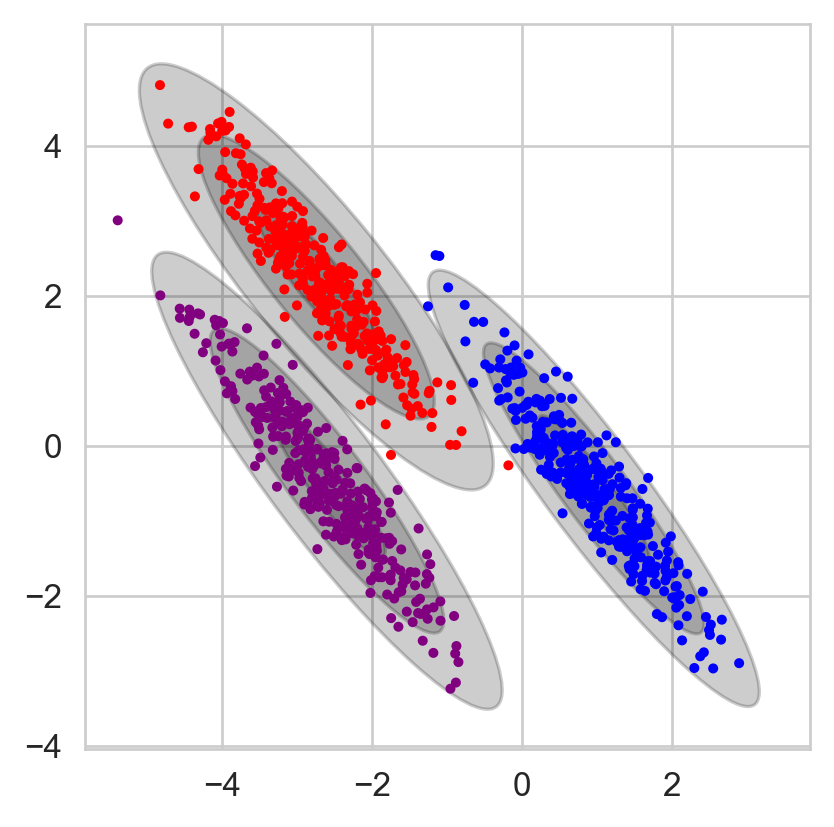

Epoch:  5 Likelihood:  -2671.549600916459


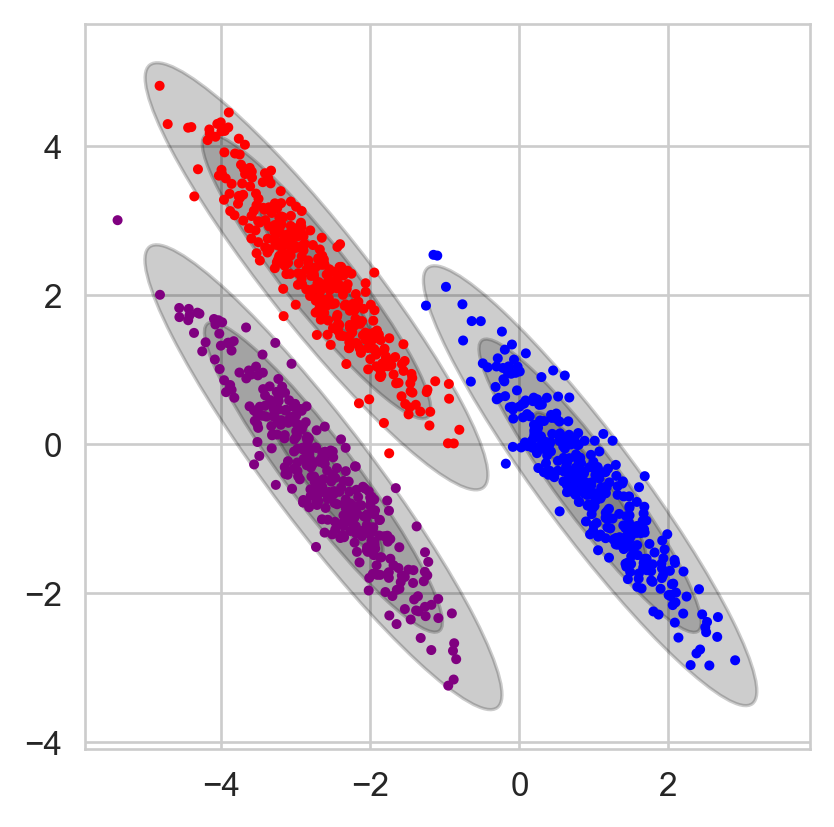

Epoch:  6 Likelihood:  -2640.1094568492376


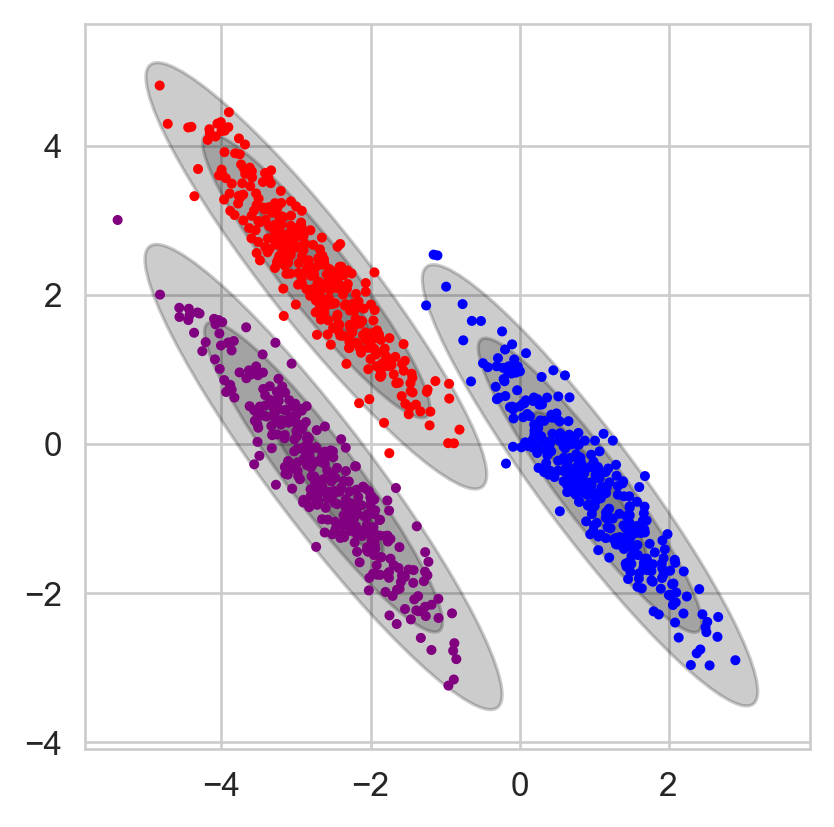

Epoch:  7 Likelihood:  -2639.884009925117


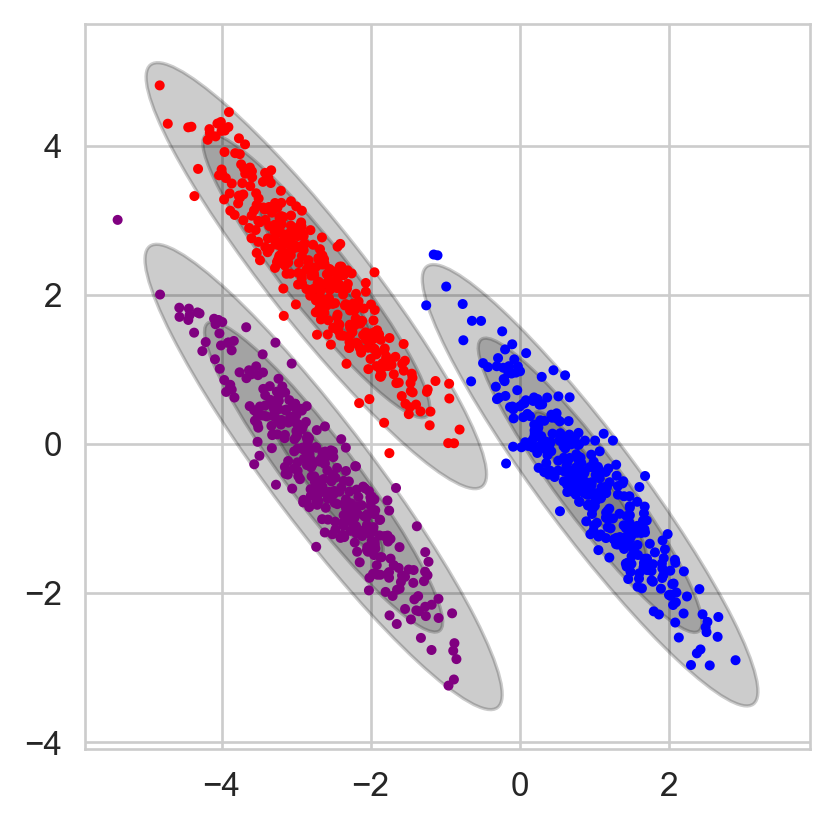

Epoch:  8 Likelihood:  -2639.8809687969865


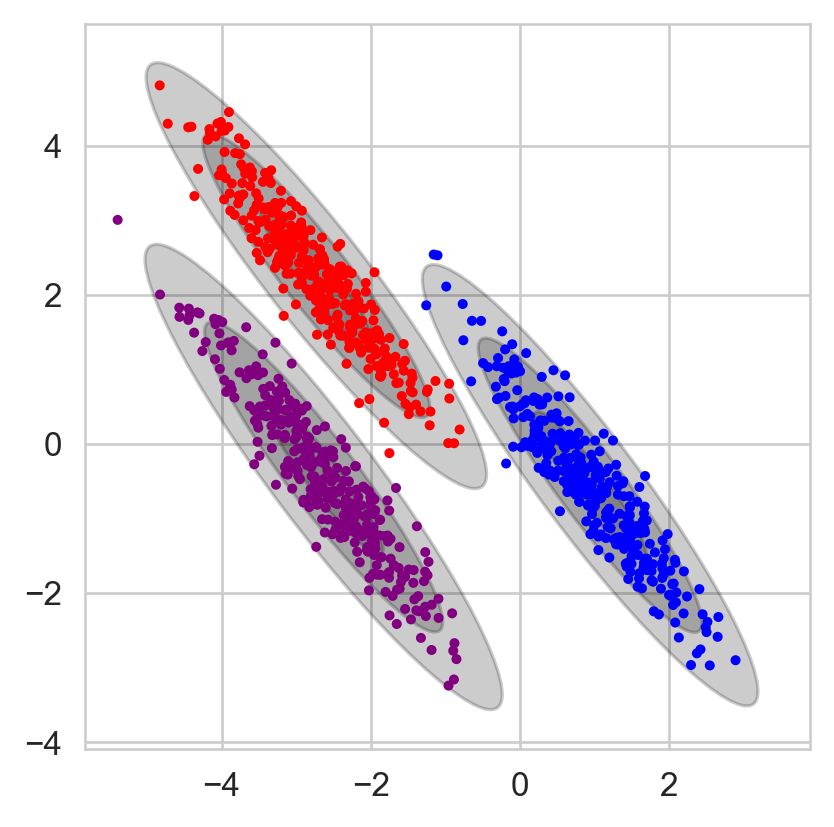

Epoch:  9 Likelihood:  -2639.8809014029466


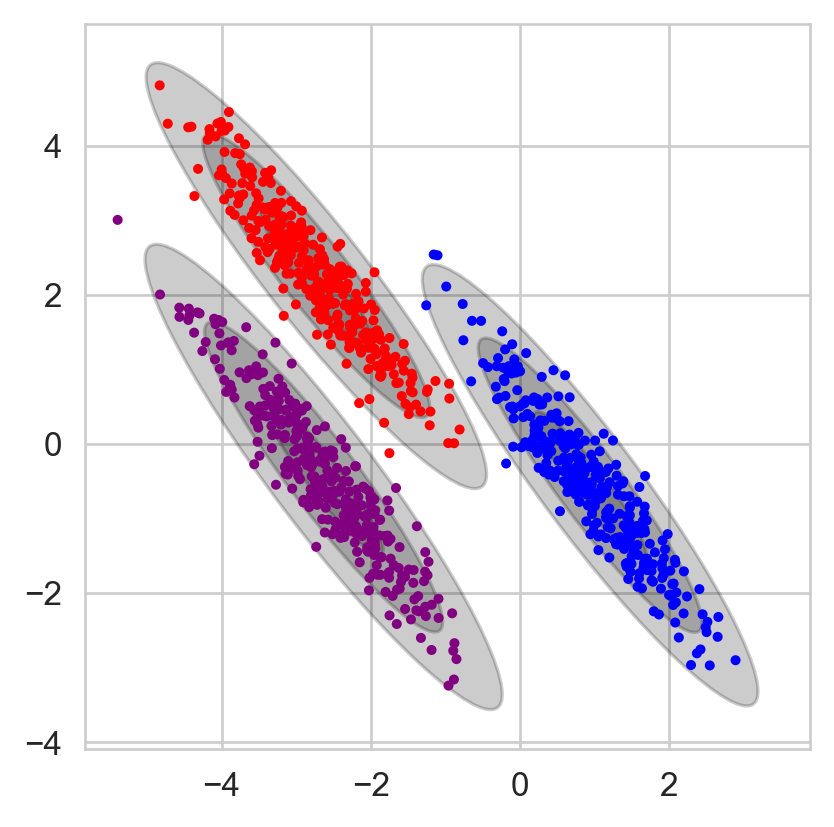

Epoch:  10 Likelihood:  -2639.8808998754225


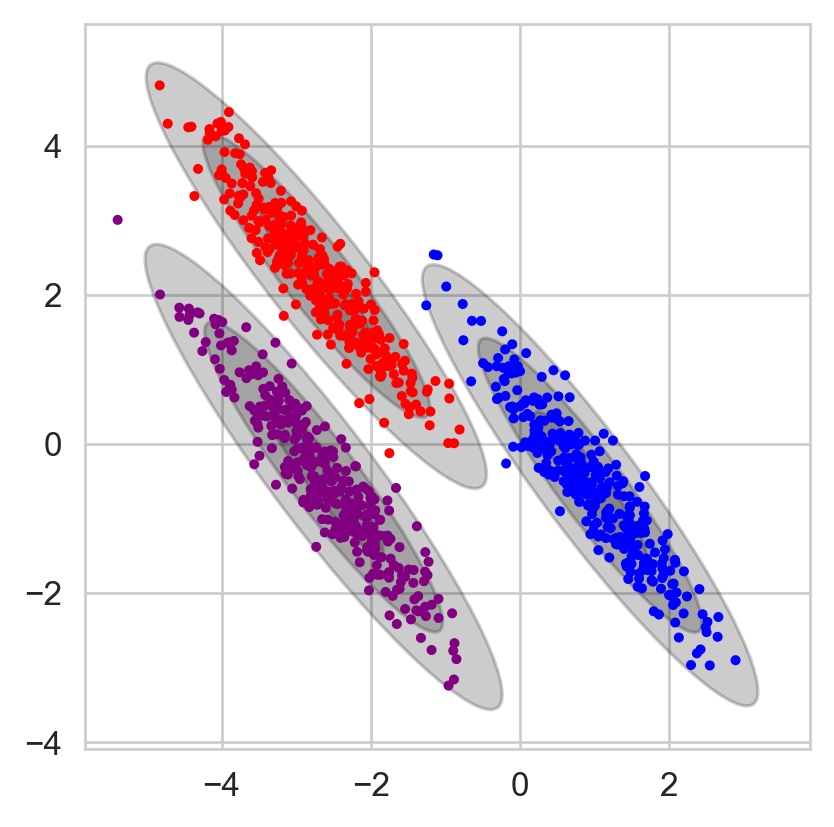

Epoch:  11 Likelihood:  -2639.8808998400614


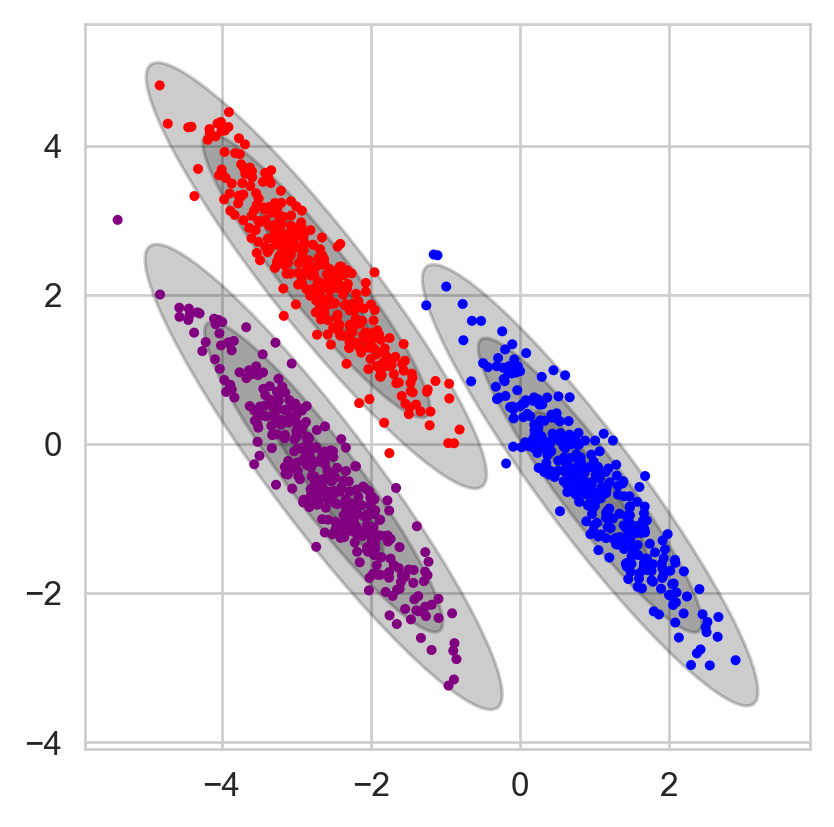

Improvement smaller than threshold! Finished Training
Time of GMM self-implementation: 3.023691599999893


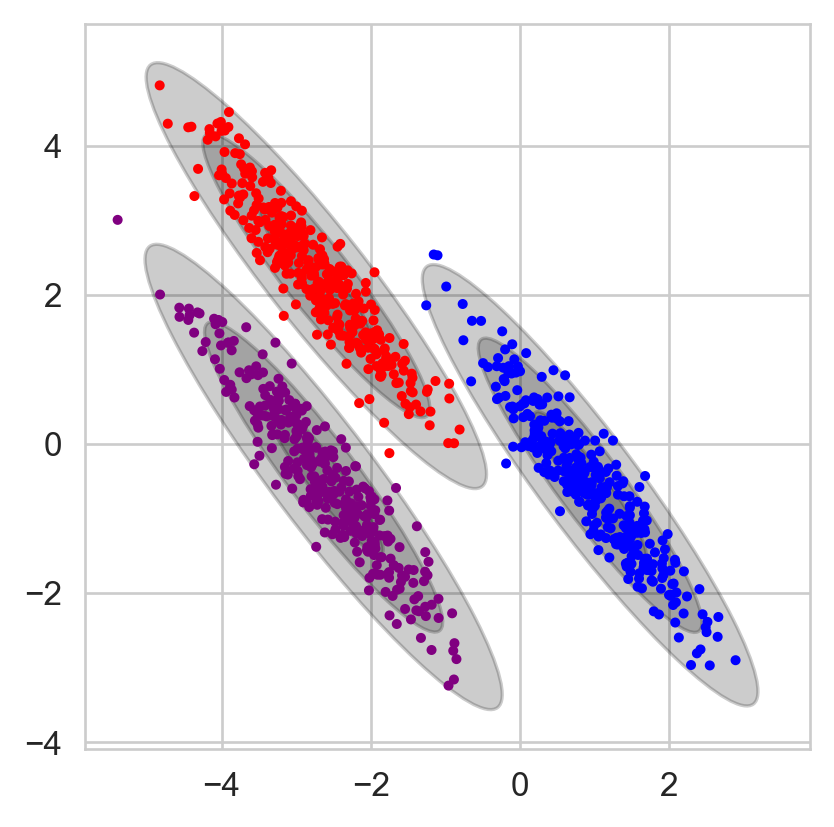

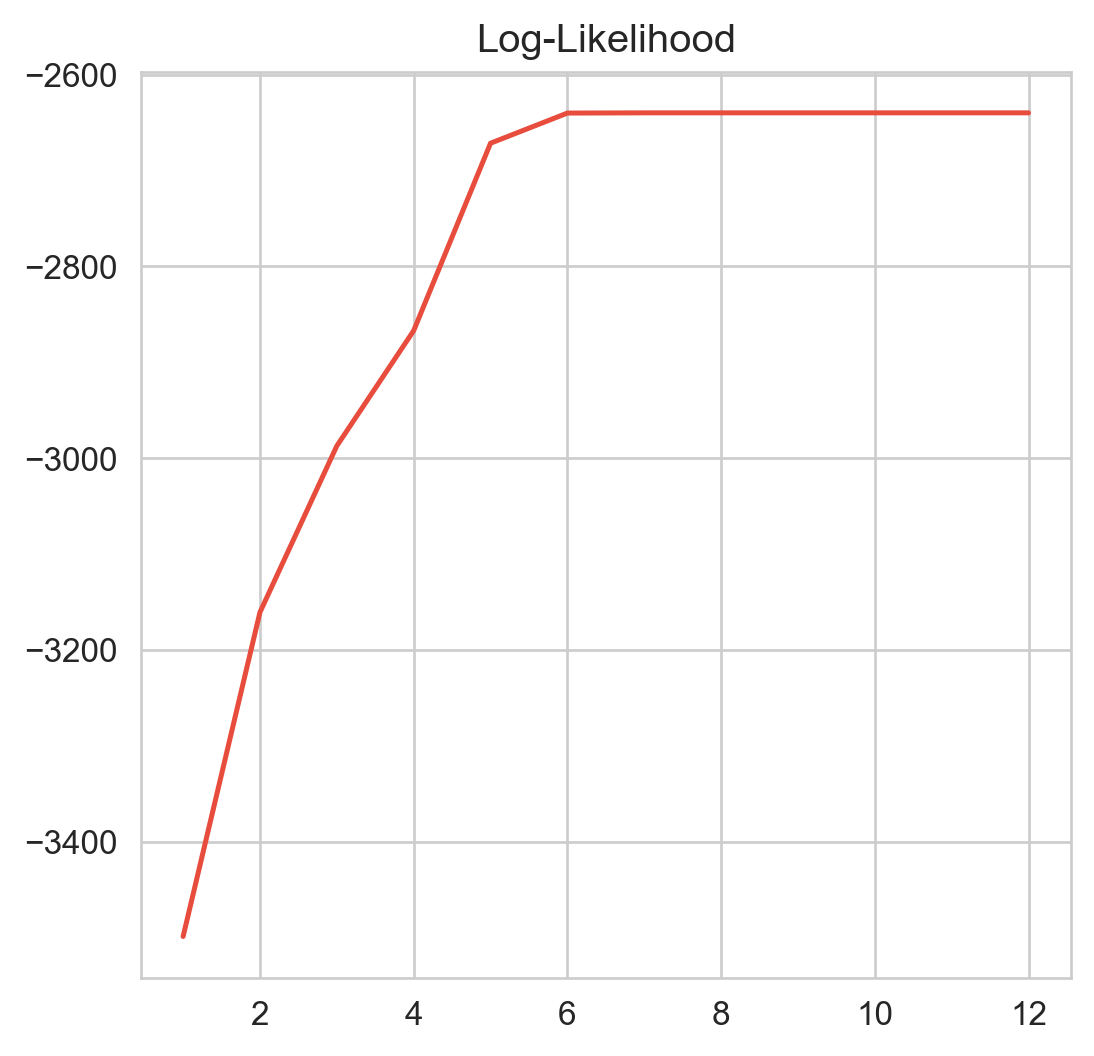

In [23]:
gmm_2D_dataset(X_aniso, 3, 1)
# sau 3 epochs thì plot các Gaussian đã tìm được ở bước hiện tại

Ta thấy cả 2 GMM đều đã phân loại được đúng datasets, điều mà thuật toán clustering như K-means phân loại không chính xác. 

Nhìn các Gaussian sau các bước của thuật toán EM thay đổi, ta thấy rõ cách mà GMM cải tiến hơn so với K-means.

Tiếp theo, ta sẽ chạy trên một dataset 2D mà các thuật toán như K-means cũng không phân loại một cách chính xác được.

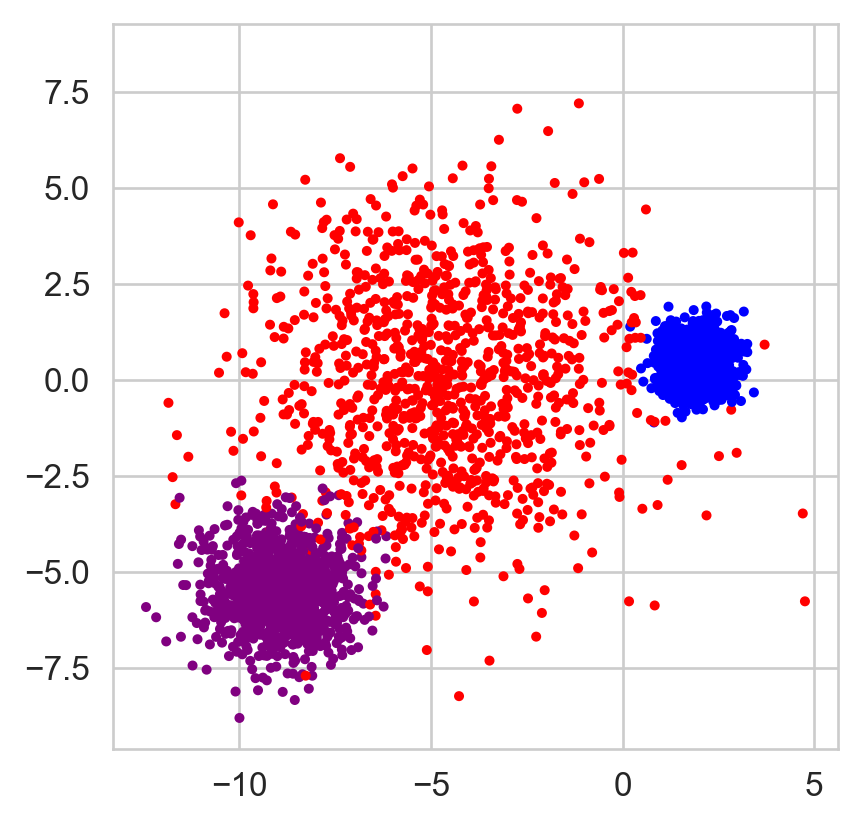

In [24]:
X_blobs, y = datasets.make_blobs(n_samples=3000,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=170)
sns.set_style('whitegrid')
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c = y, cmap=matplotlib.colors.ListedColormap(colors))
plt.axis('square')
plt.show()

Initialization 0
Initialization converged: True	 time lapse 0.01500s	 ll -4.00599
Time of GMM sklearn: 0.017298299999993105


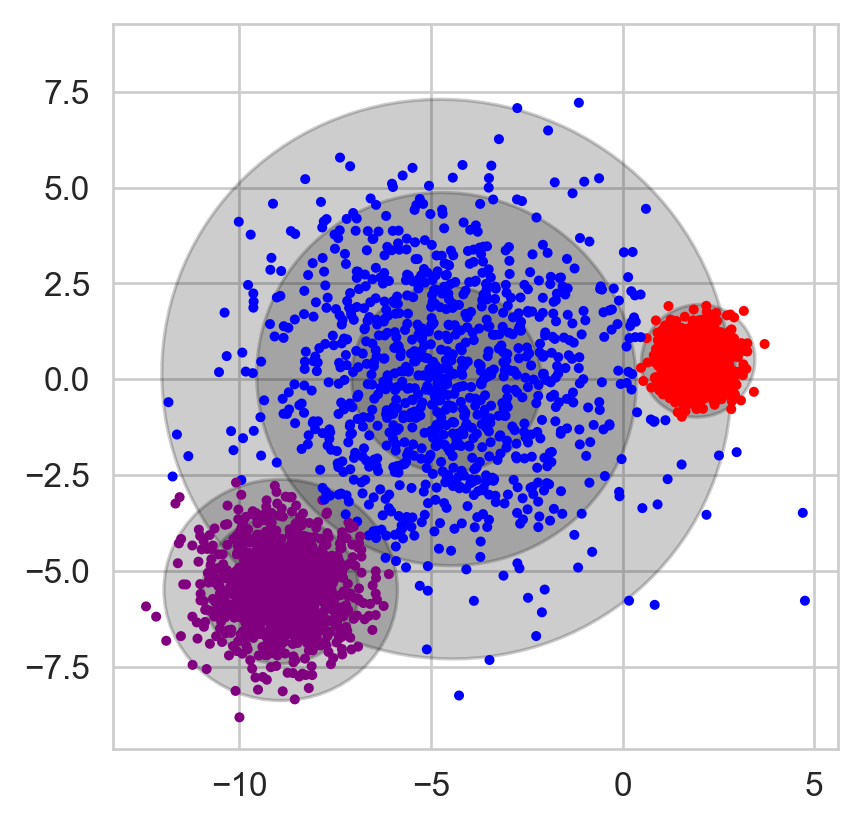

In [25]:
gmm_sklearn_2D_dataset(X_blobs, 3, 1)

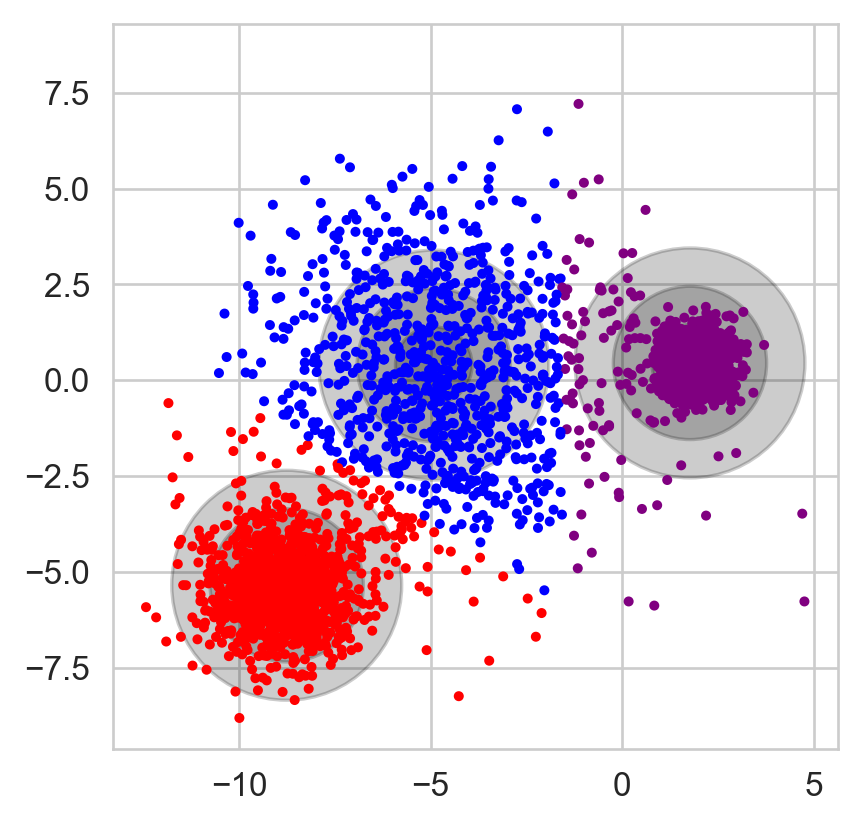

Epoch:  1 Likelihood:  -14490.116869862377
Epoch:  2 Likelihood:  -12606.546382573477
Epoch:  3 Likelihood:  -12126.978000270346
Epoch:  4 Likelihood:  -12031.97272338689
Epoch:  5 Likelihood:  -12019.782434472028


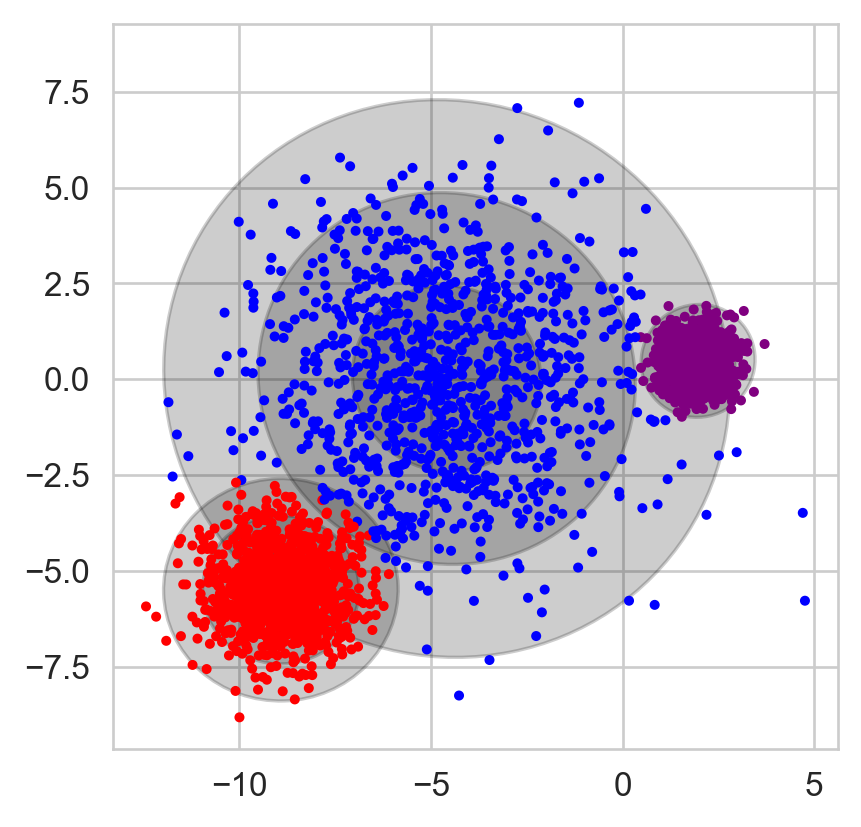

Epoch:  6 Likelihood:  -12017.979724248766
Epoch:  7 Likelihood:  -12017.592295802
Epoch:  8 Likelihood:  -12017.490576150427
Epoch:  9 Likelihood:  -12017.461744139917
Epoch:  10 Likelihood:  -12017.453338885833


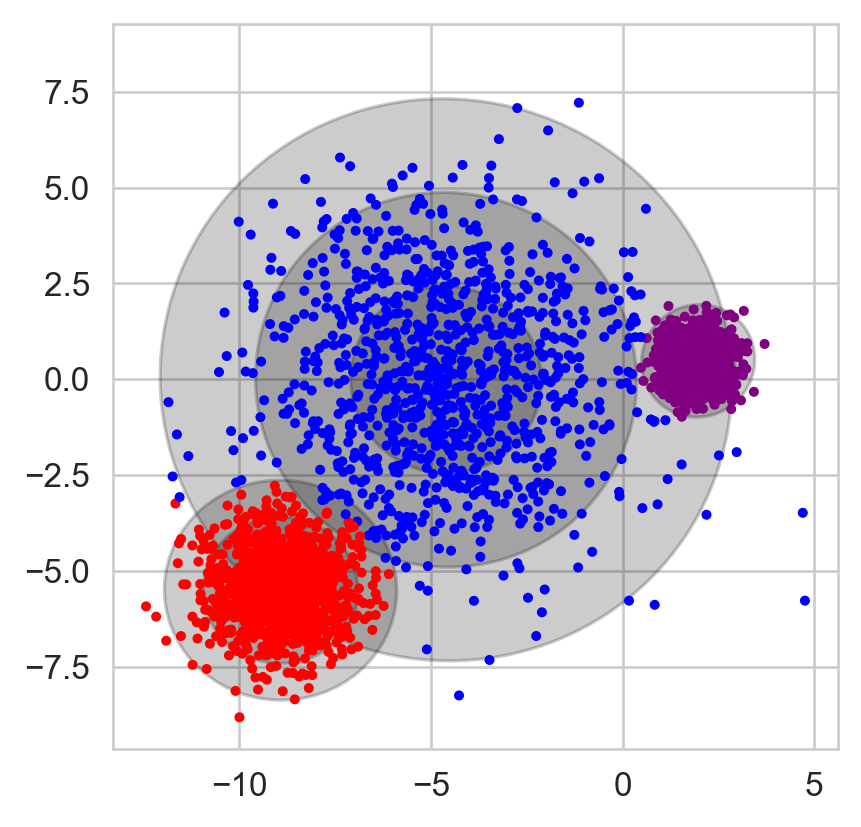

Epoch:  11 Likelihood:  -12017.450861619727
Epoch:  12 Likelihood:  -12017.450128105374
Epoch:  13 Likelihood:  -12017.449910447722
Epoch:  14 Likelihood:  -12017.449845793552
Epoch:  15 Likelihood:  -12017.449826577951


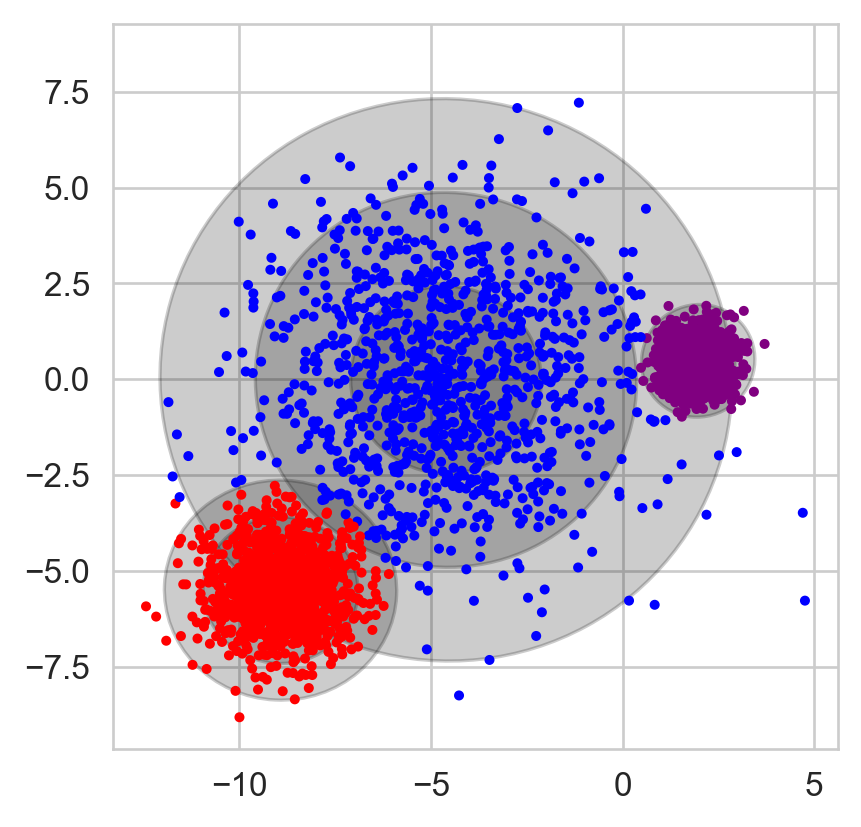

Epoch:  16 Likelihood:  -12017.449820865333
Epoch:  17 Likelihood:  -12017.449819166768
Epoch:  18 Likelihood:  -12017.44981866168
Epoch:  19 Likelihood:  -12017.44981851148
Epoch:  20 Likelihood:  -12017.449818466815


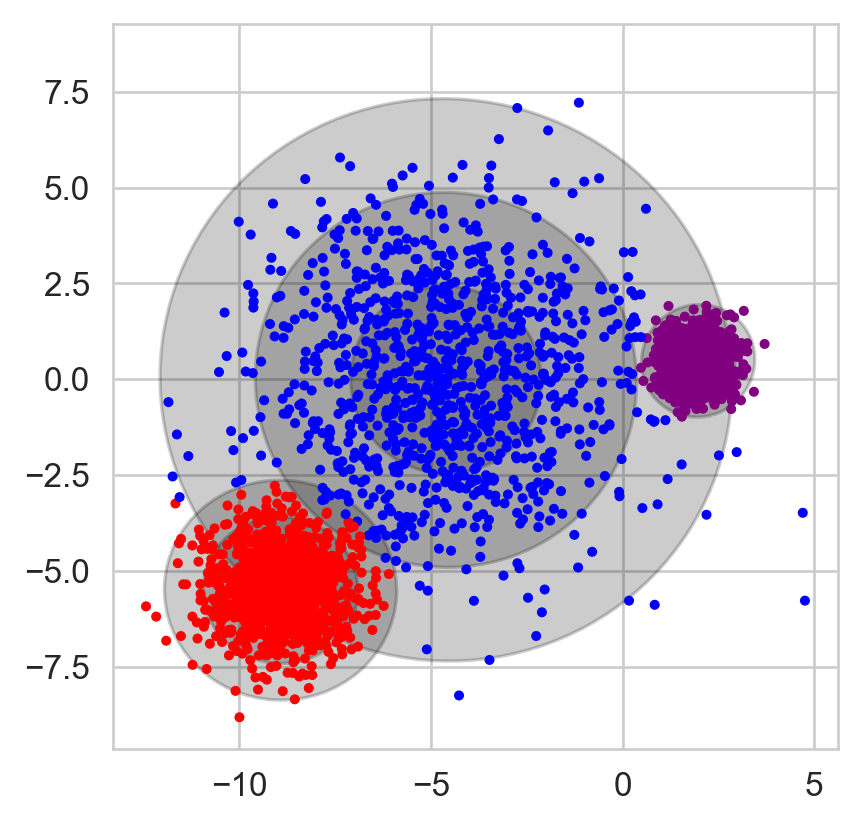

Epoch:  21 Likelihood:  -12017.449818453531
Epoch:  22 Likelihood:  -12017.44981844958
Epoch:  23 Likelihood:  -12017.449818448407
Improvement smaller than threshold! Finished Training
Time of GMM self-implementation: 6.2477651000001515


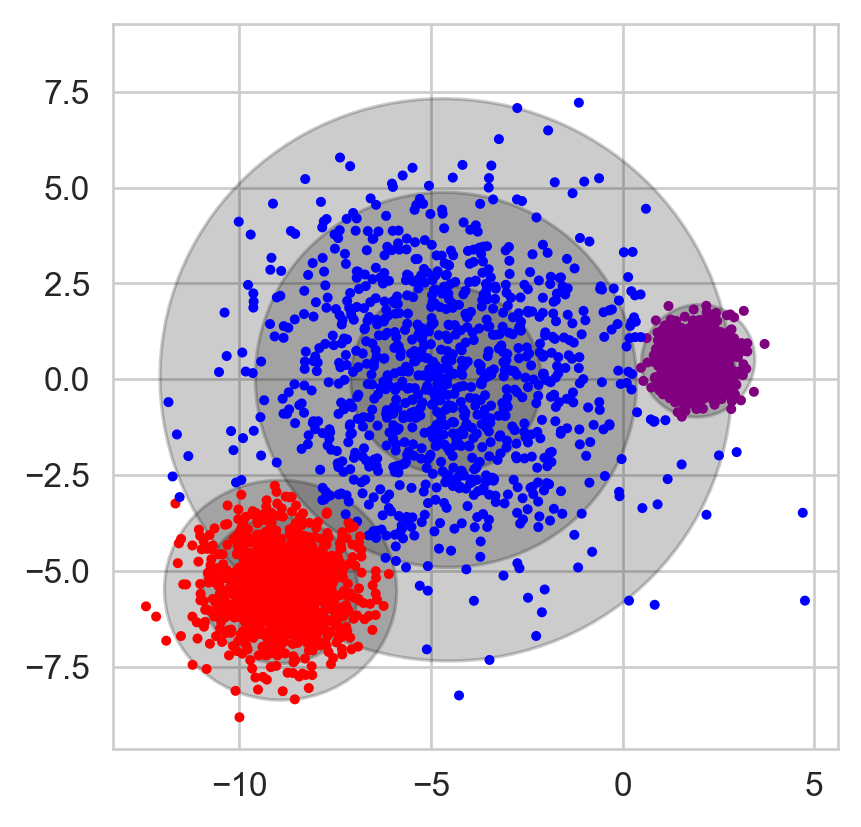

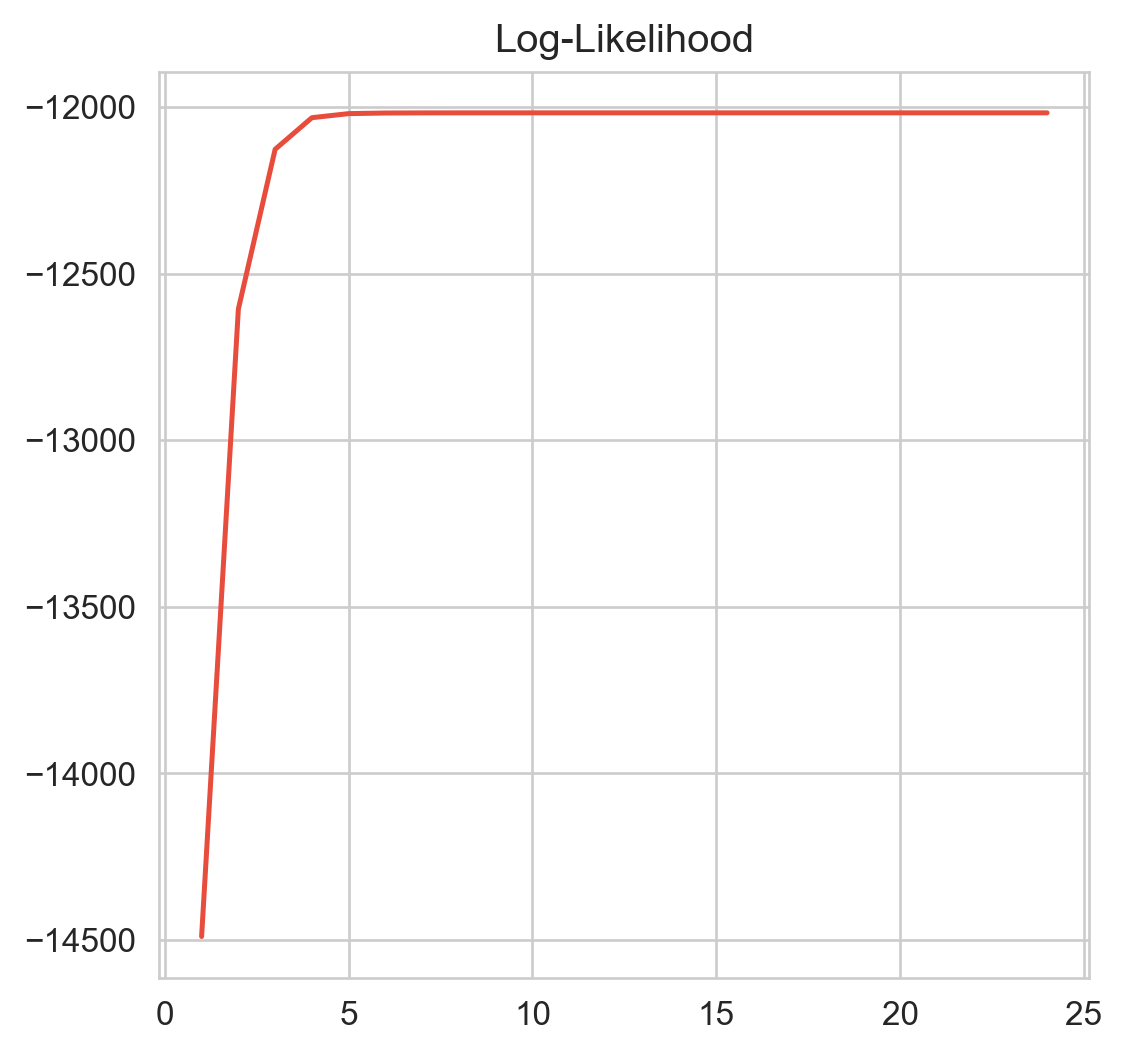

In [26]:
gmm_2D_dataset(X_blobs, 3, 5)

GMM nhóm cụm một cách chính xác mặc dù phân phối của 3 cụm có độ lệch chuẩn khác nhau rõ rệt.

Tiếp đến ta sẽ xem một số datasets 2D mà GMM chưa thể phân cụm chính xác 

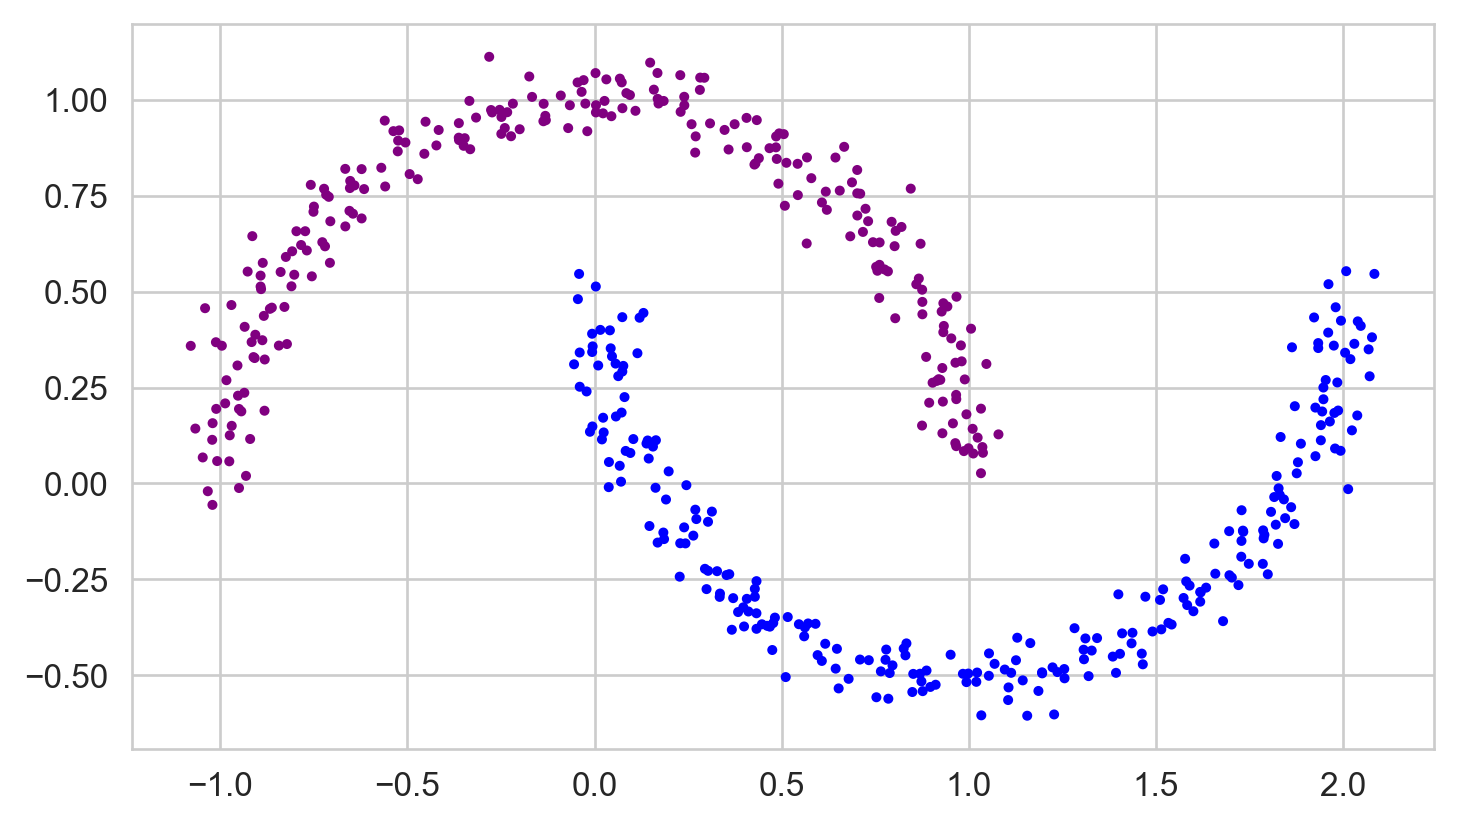

In [27]:
X_moon, y_moon = datasets.make_moons(500, noise=0.05, random_state=42)
sns.set_style('whitegrid')
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap=matplotlib.colors.ListedColormap(colors));

Initialization 0
Initialization converged: True	 time lapse 0.00699s	 ll -1.71401
Time of GMM sklearn: 0.007840799999939918


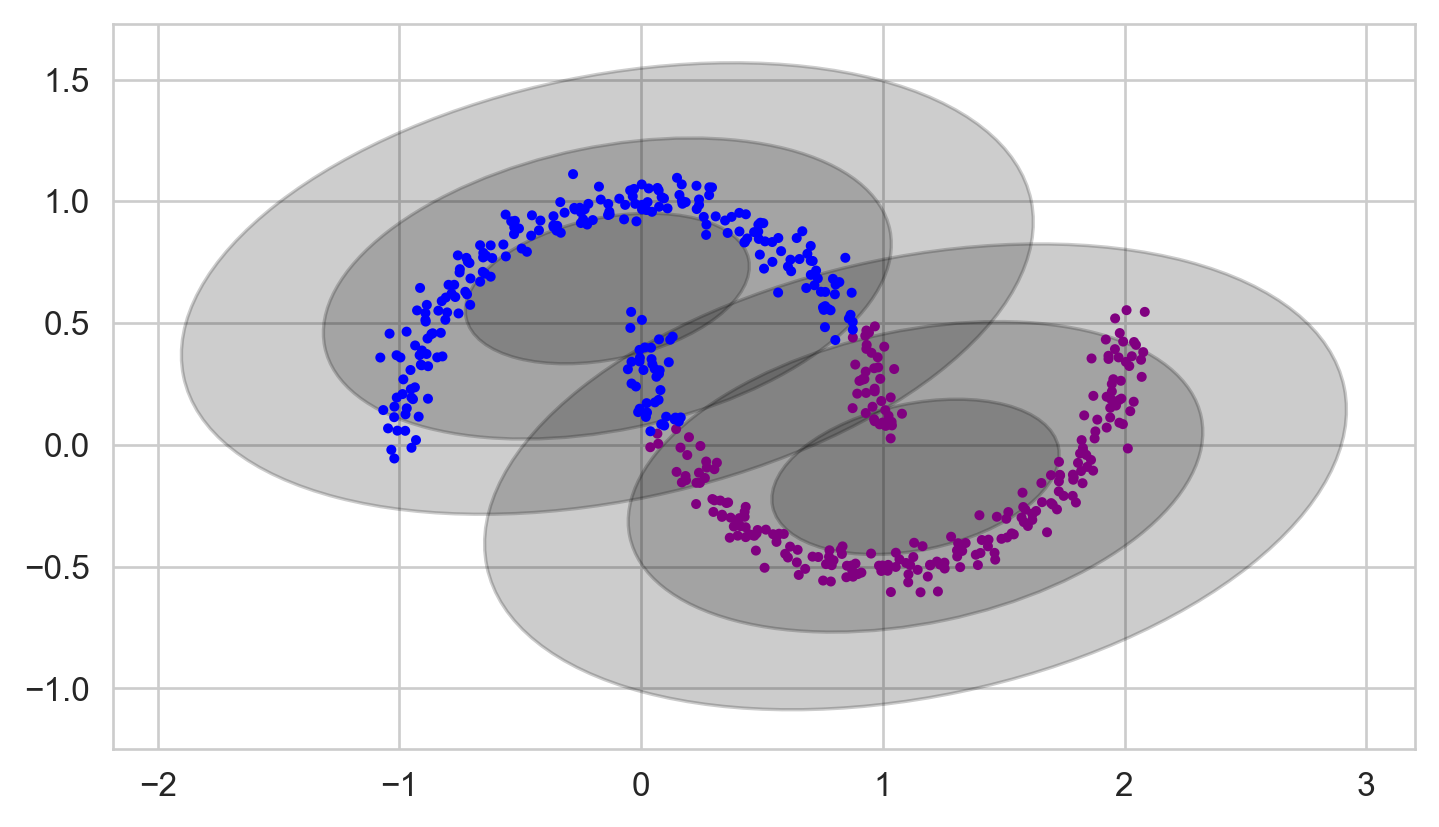

In [28]:
gmm_sklearn_2D_dataset(X_moon, 2, 1, 0)

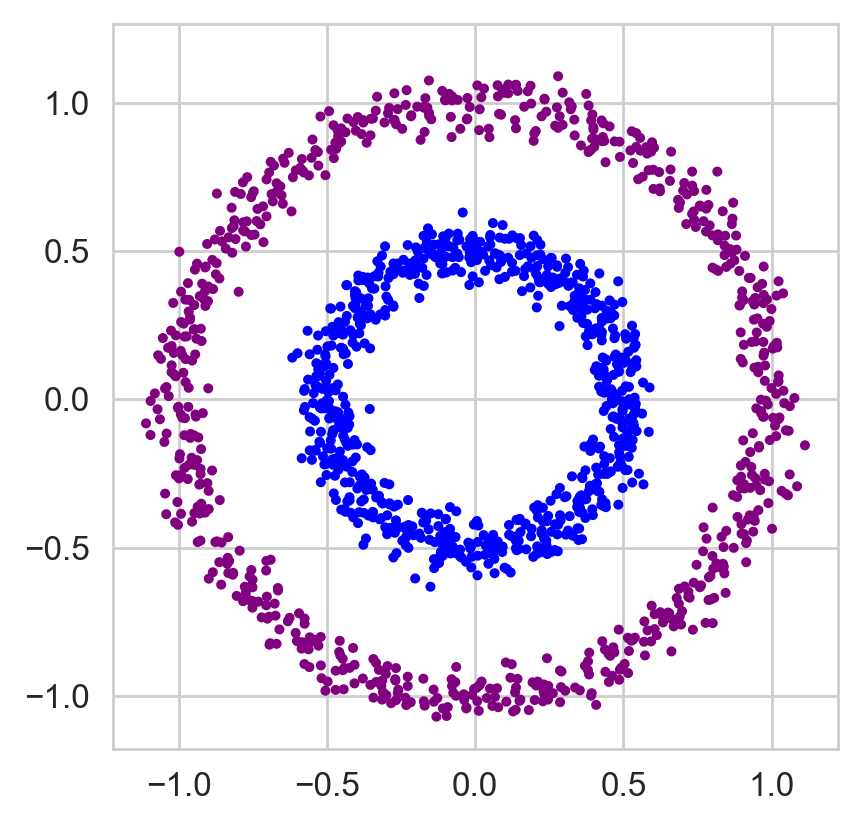

In [29]:
X_cir, y_cir = datasets.make_circles(n_samples=1500, factor=.5, noise=.05)
sns.set_style('whitegrid')
plt.scatter(X_cir[:, 0], X_cir[:, 1], c=y_cir, cmap=matplotlib.colors.ListedColormap(colors));
plt.axis('square')
plt.show()

Initialization 0
Initialization converged: True	 time lapse 0.01100s	 ll -1.63854
Time of GMM sklearn: 0.011615699999993012


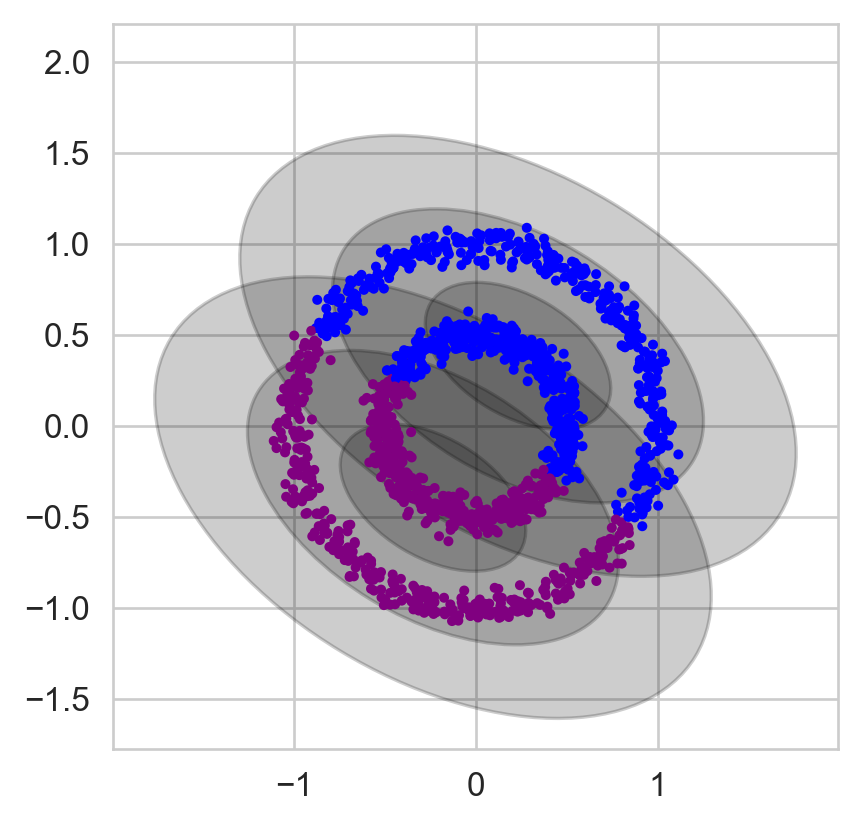

In [30]:
gmm_sklearn_2D_dataset(X_cir, 2, 1)

Ta dễ dàng thấy đối với các datasets mà các điểm dữ liệu có phân phối đặc biệt (không tuân theo phân phối Gaussian) thì GMM không thể phân cụm chính xác.

Ngoài ứng dụng trong các bài toán clustering, GMM còn dược sử dụng cho density estimation nhằm mô tả phân phối của data, từ đó được dùng như một generative model giúp sinh các data mới theo phân phối của data cho trước.

Ta hãy cùng quay lại với datasets **moon** ở trên.

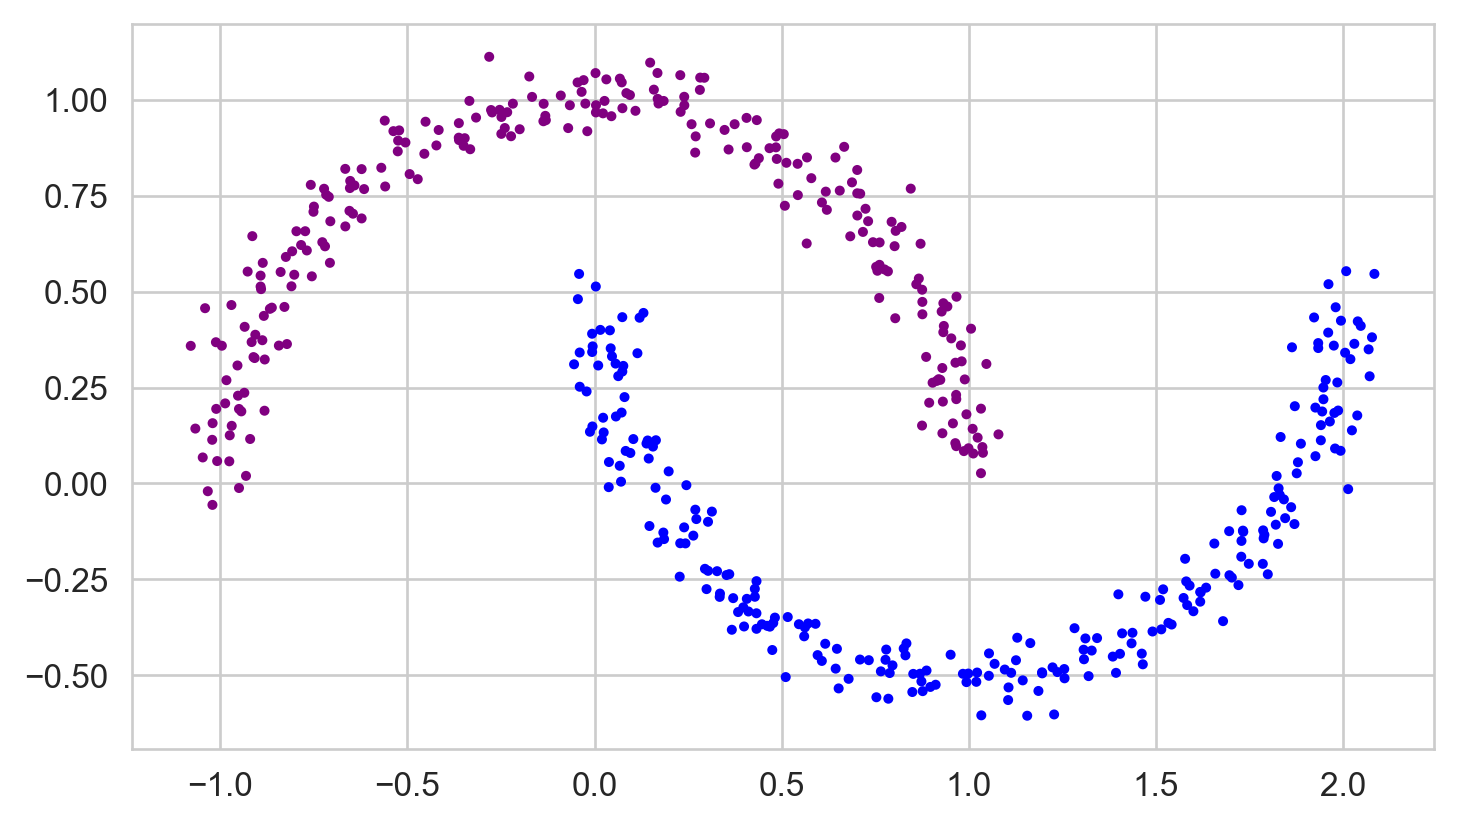

In [31]:
X_moon, y_moon = datasets.make_moons(500, noise=0.05, random_state=42)
sns.set_style('whitegrid')
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap=matplotlib.colors.ListedColormap(colors));

Khi ta dùng GMM với số lượng cụm khoảng 8, thì ta sẽ được một mô tả khá chính xác phân phối của dữ liệu, ta sẽ dùng các phân phối Gaussian đó để sinh ra các dữ liệu mới.

Initialization 0
  Iteration 10	 time lapse 0.02300s	 ll change 0.00155
Initialization converged: True	 time lapse 0.02900s	 ll -0.42189


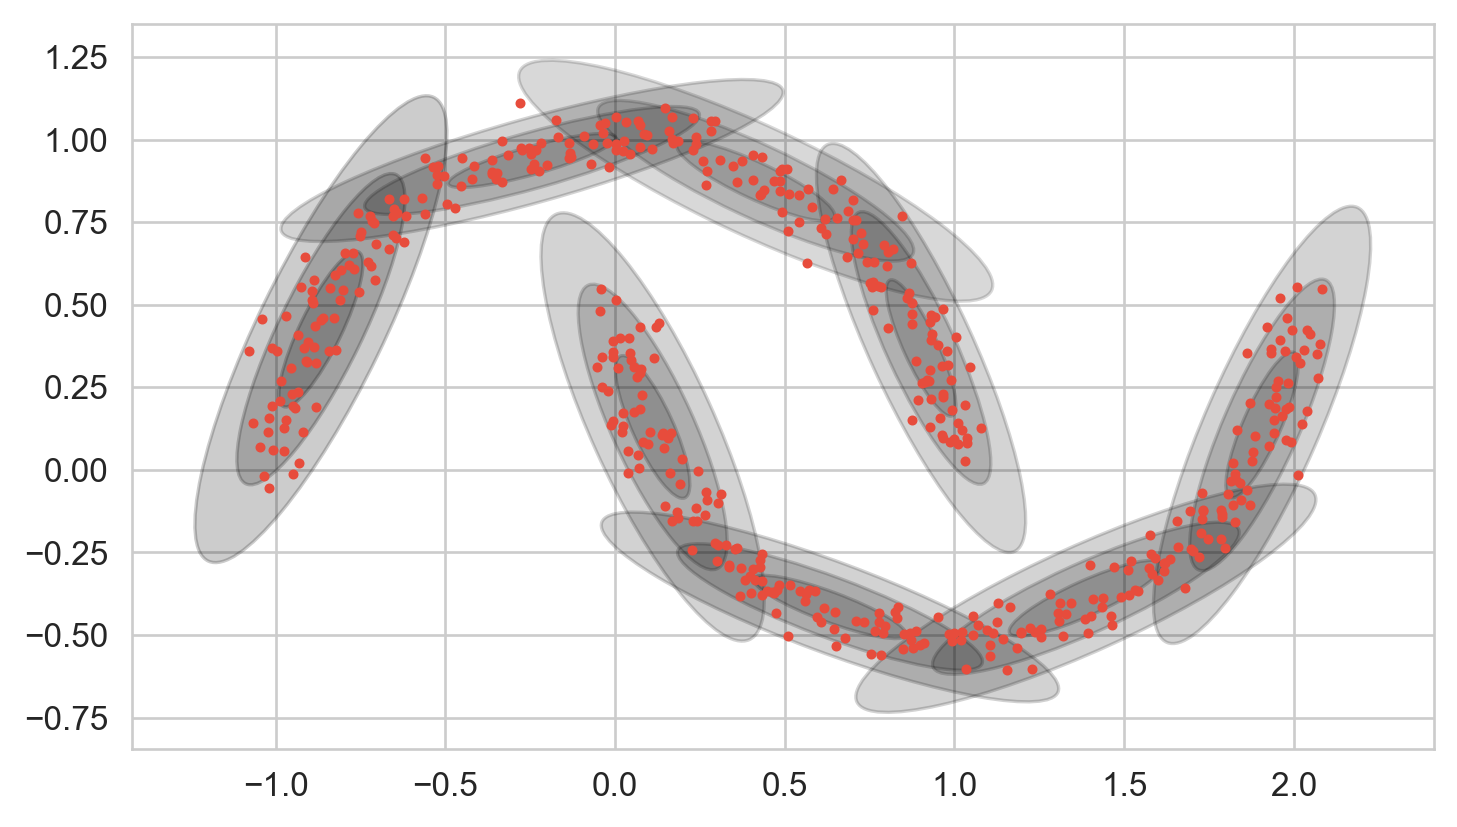

In [32]:
gmm = GaussianMixture(n_components=8, verbose=2, random_state=42)
gmm.fit(X_moon)
sns.set_style('whitegrid')
plot_gmm(X_moon, [], gmm.means_, gmm.covariances_, gmm.weights_, 0, 0)

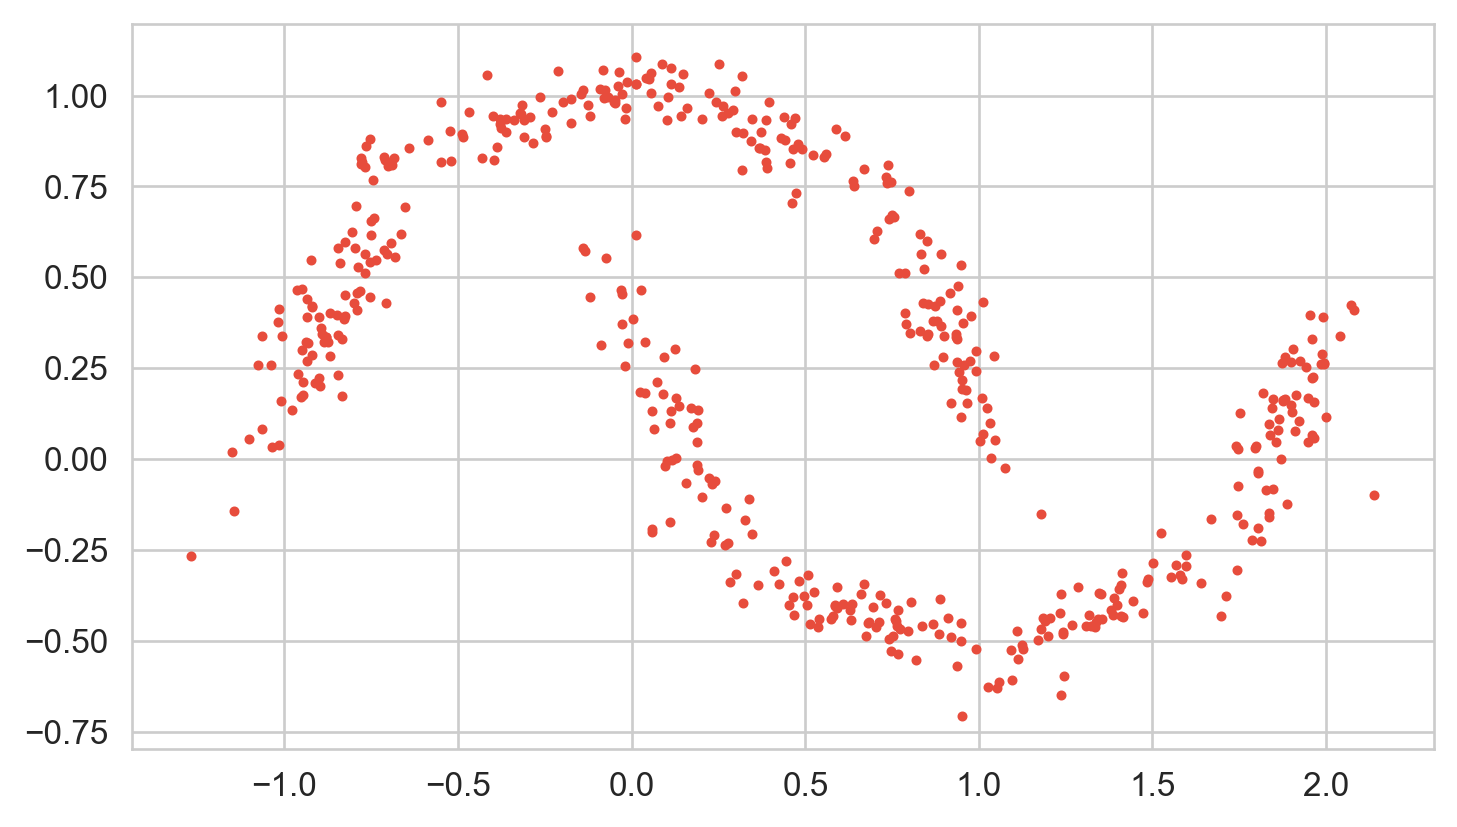

In [33]:
# Generate các data mới theo phân phối của data trên
X_new, y_new = gmm.sample(500)
sns.set_style('whitegrid')
plt.scatter(X_new[:, 0], X_new[:, 1]);

500 điểm data mới được sinh ra dựa trên 8 Gaussian model mà GMM đã phân cụm.

Ta sẽ dễ dàng thấy rằng nếu ta tăng số cụm của GMM lên càng nhiều, thì log-likelihood sẽ càng tăng. Nhưng đôi khi việc phân bằng số cụm nhiều thì model của ta sẽ không đủ "general" để đưa ra được các cách nhóm cụm hữu ích, hoặc nếu số cụm ít quá thì model sẽ không đủ "detailed" để mô tả các đặc điểm nổi bật của data.
Vì vậy, ta sẽ sử dụng AIC và BIC để có thể chọn số cụm sao cho phù hợp với data.

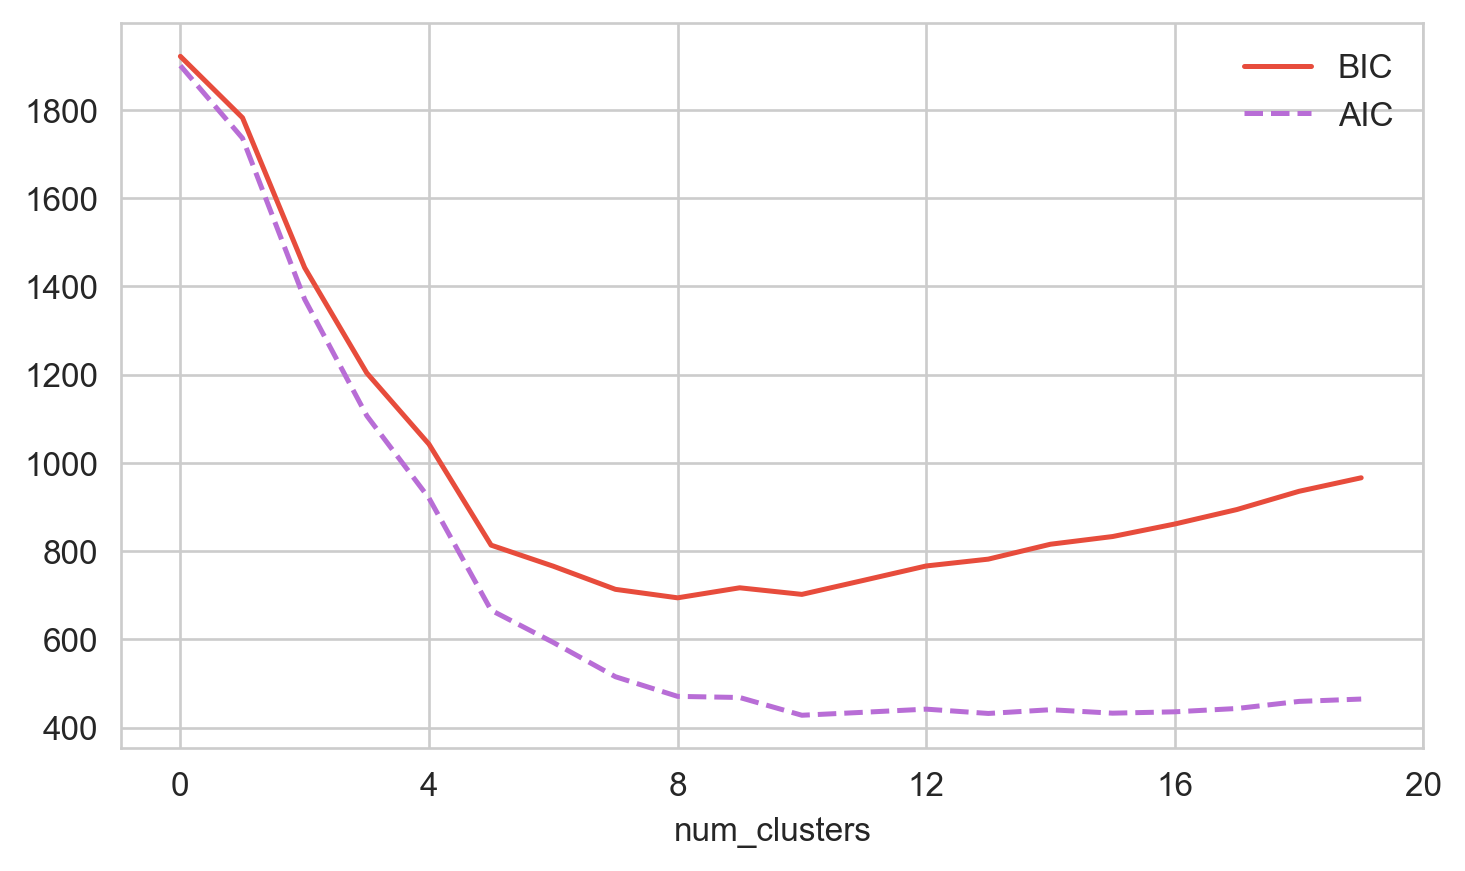

In [34]:
models = [GaussianMixture(num, random_state=42).fit(X_moon)
          for num in range(1, 21)]
sns.set_style('whitegrid')
plt.plot([m.bic(X_moon) for m in models], label='BIC')
plt.plot([m.aic(X_moon) for m in models], label='AIC')
plt.xticks(range(0,21, 4))
plt.legend()
plt.xlabel('num_clusters');

Ta thấy số cụm nên sử dụng cho GMM để mô tả hiệu quả phân phối **X_moon** là vào khoảng từ 8 đến 12, vùng mà minimize giá trị AIC và BIC.

# <a id='4'>4. GMM for generating handwritten digits</a>

Ta sẽ lấy data handwritten digits từ thư viện sklearn, mỗi digit sẽ được biểu diễn bằng 64 pixels. Sau đó ta sẽ sử dụng GMM như một generative model để sinh ra các digits mới.

In [35]:
digits = datasets.load_digits()
digits.data.shape

(1797, 64)

In [36]:
def plot_digits(data):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

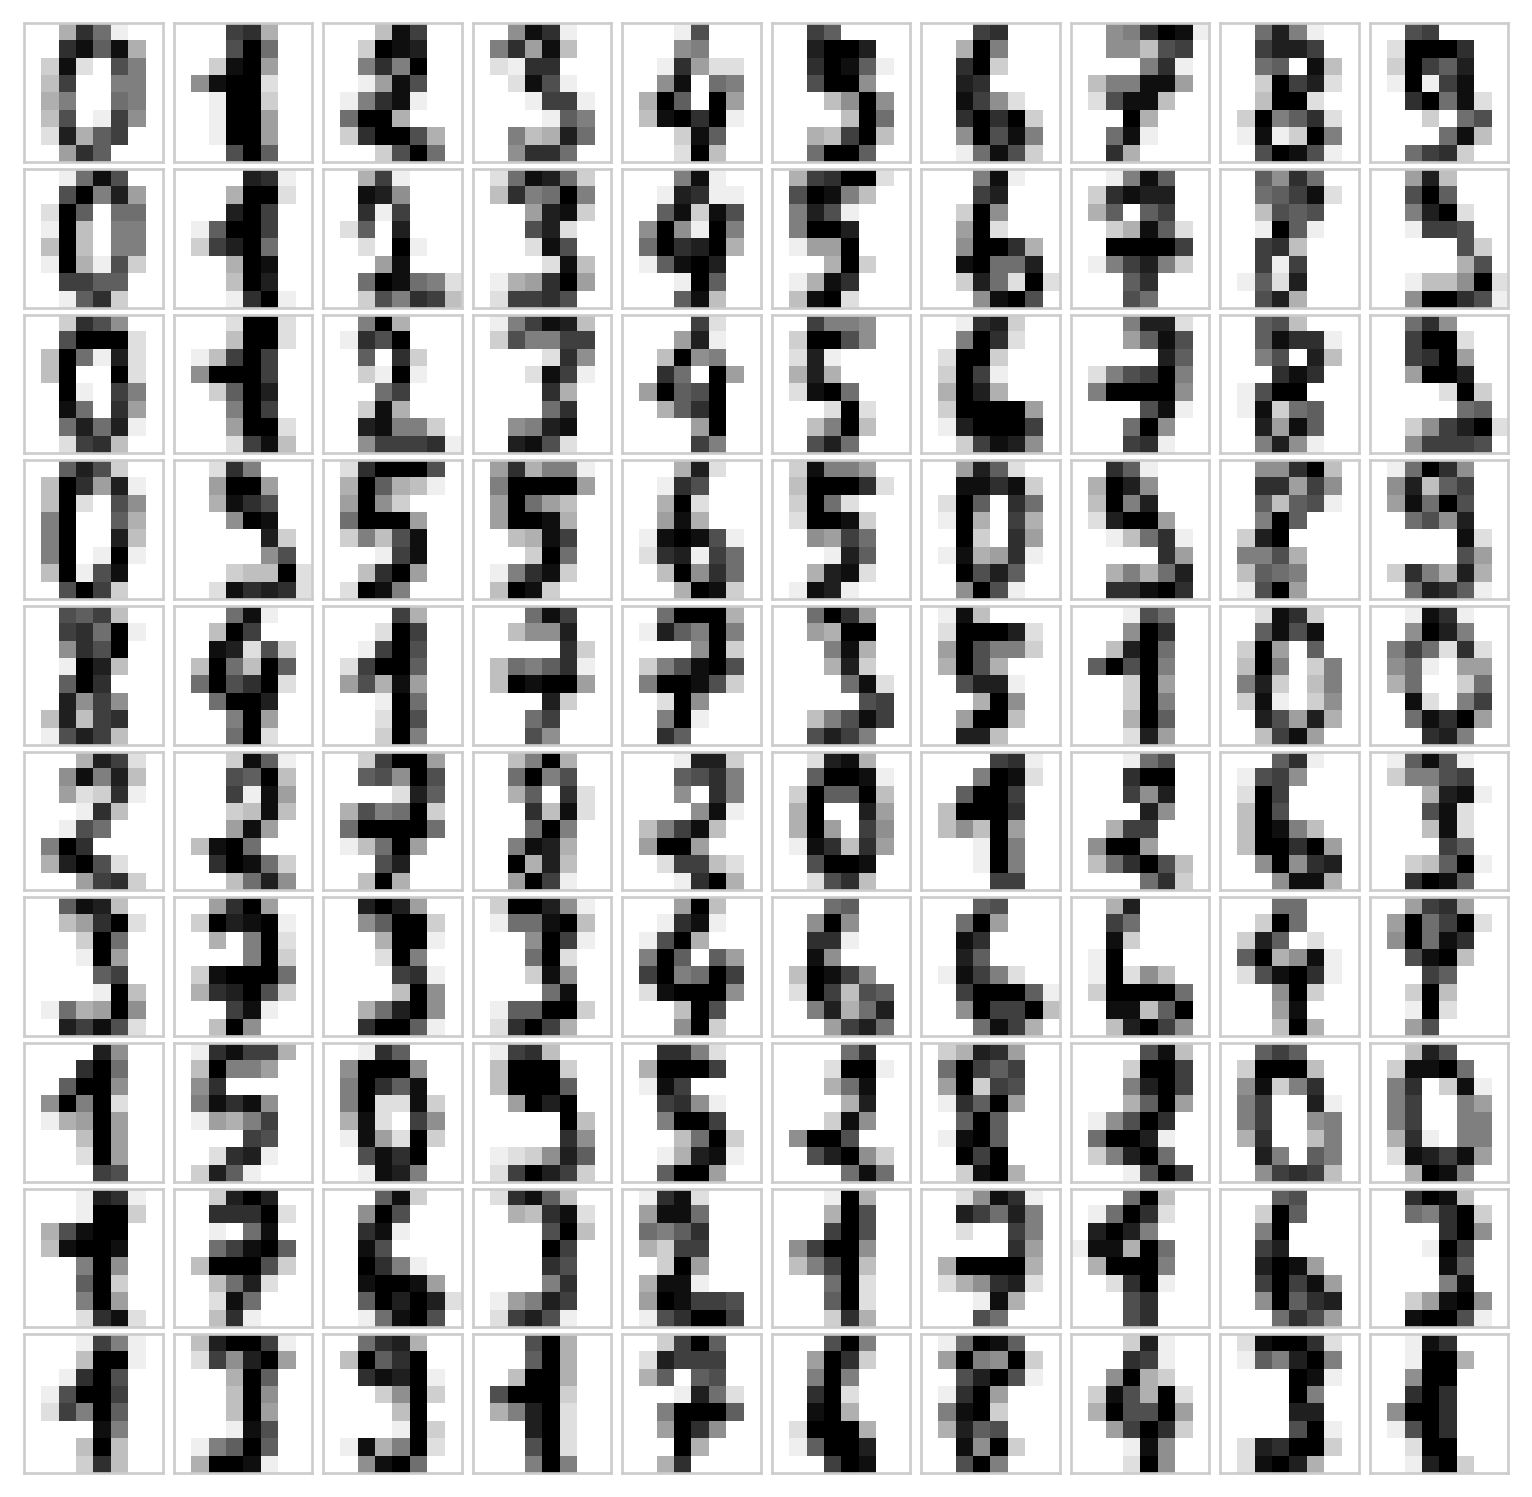

In [37]:
plot_digits(digits.data)

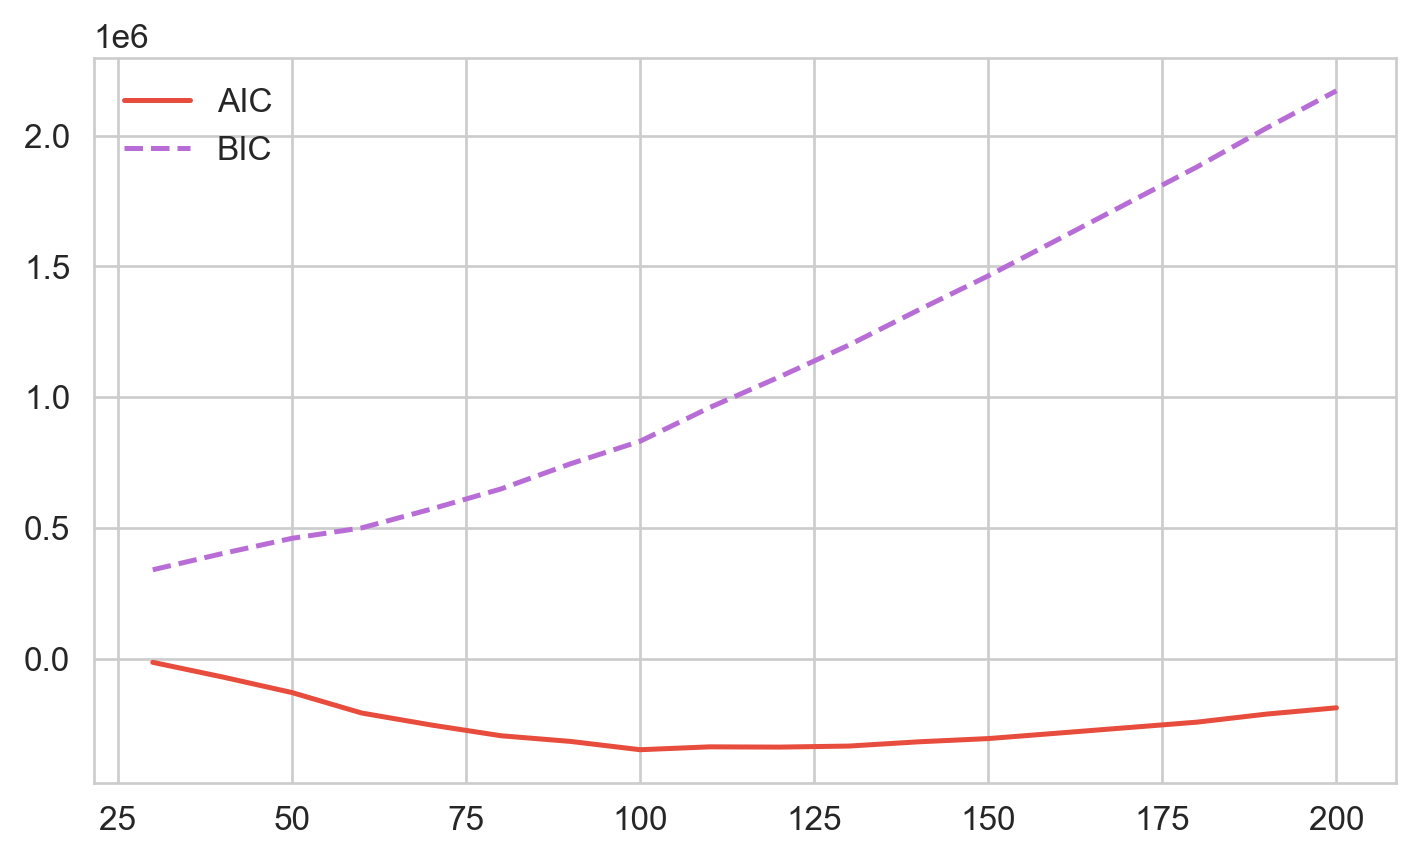

In [38]:
models = [GaussianMixture(n, random_state=42)
          for n in range(30, 210, 10)]
sns.set_style('whitegrid')
plt.plot(range(30, 210, 10), [model.fit(digits.data).aic(digits.data) for model in models], label='AIC');
plt.plot(range(30, 210, 10), [model.fit(digits.data).bic(digits.data) for model in models], label='BIC');
plt.legend()
plt.show()

Ta sẽ sử dụng GMM với 100 cụm

In [39]:
gmm = GaussianMixture(n_components=100, verbose=2, random_state=42)
gmm.fit(digits.data)

Initialization 0
Initialization converged: True	 time lapse 0.48011s	 ll 215.66135


GaussianMixture(n_components=100, random_state=42, verbose=2)

In [40]:
new_data, _ = gmm.sample(100)

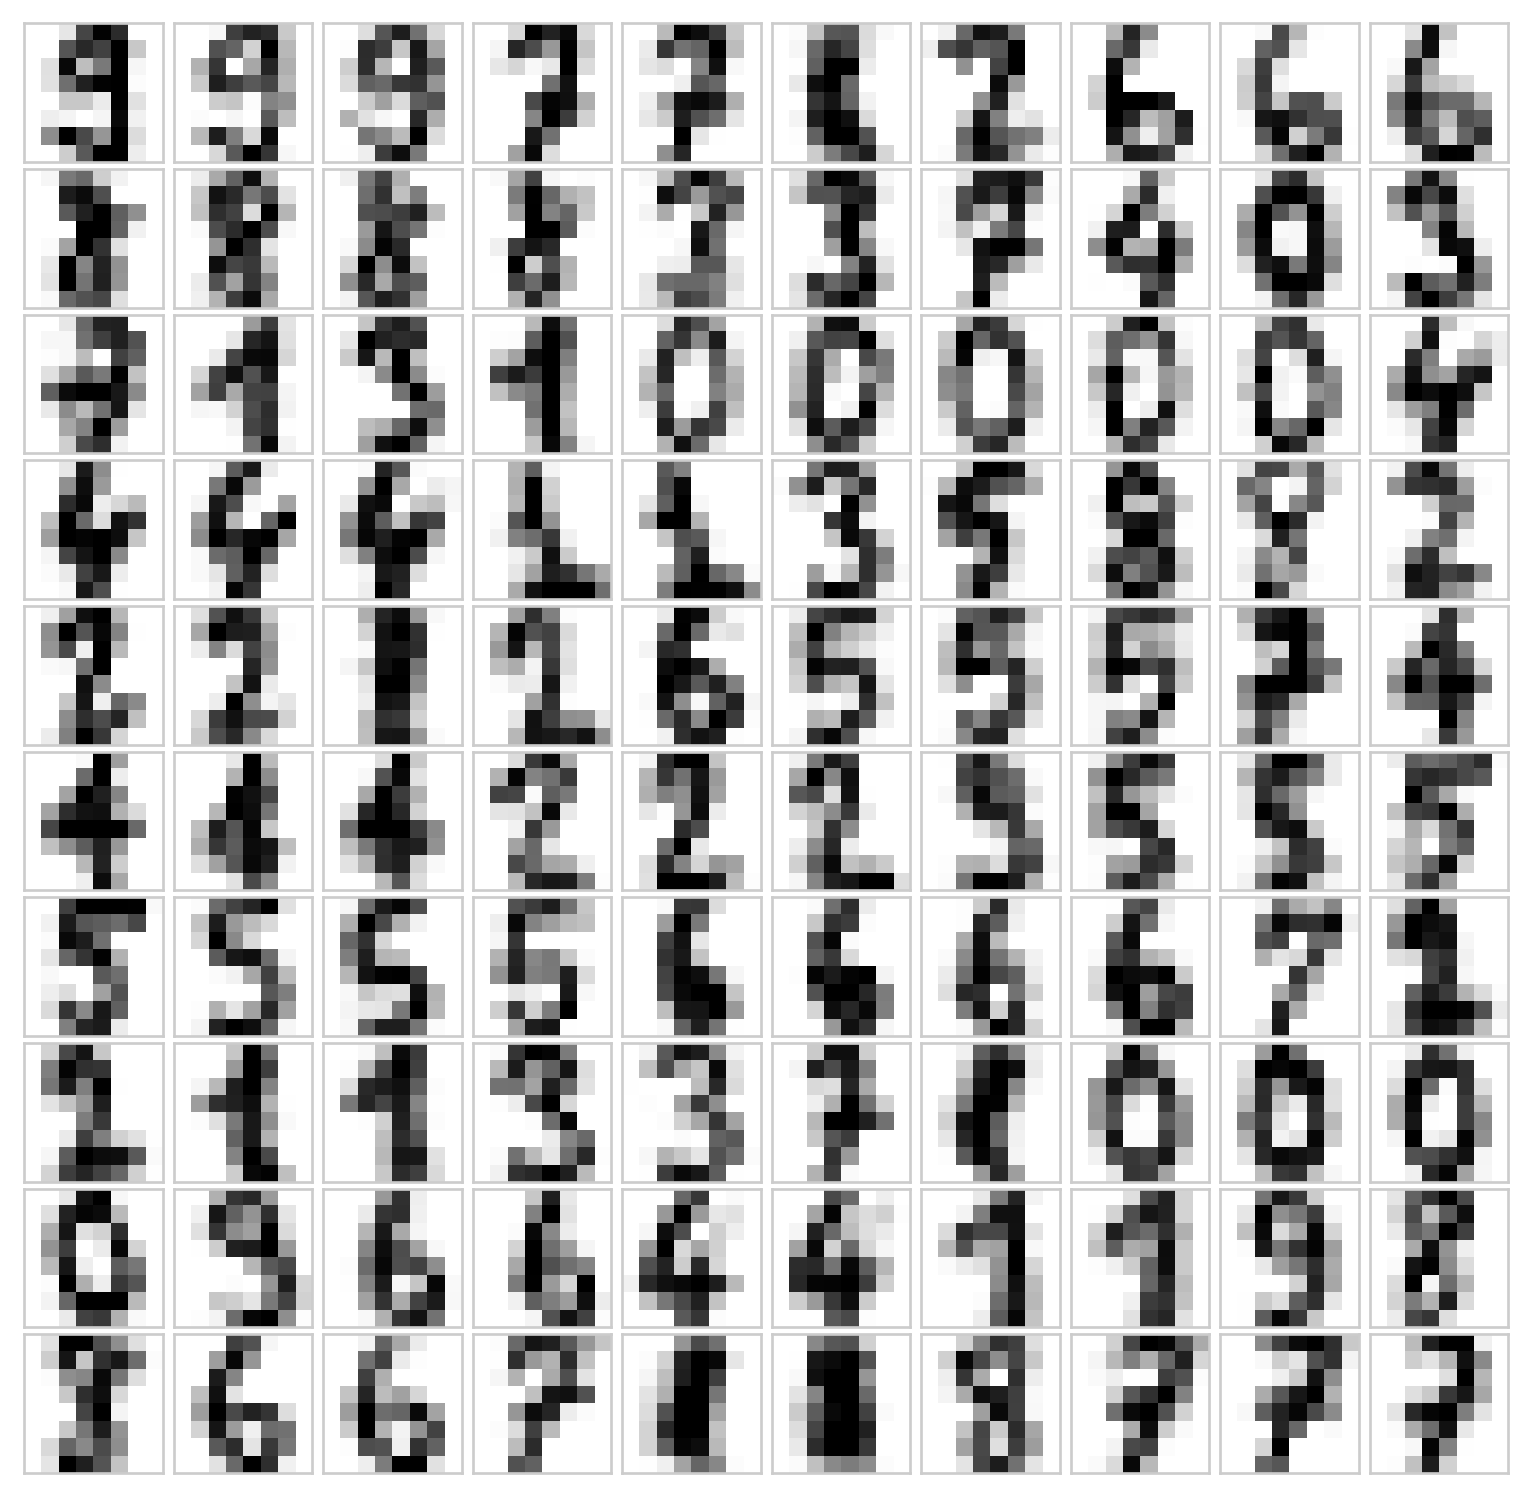

In [41]:
plot_digits(new_data)